References

1) https://towardsdatascience.com/how-to-train-a-custom-object-detection-model-with-yolo-v5-917e9ce13208

2) A Comparative Study of YOLOv5 and YOLOv7
Object Detection Algorithms by Oluwaseyi Ezekiel Olorunshola, et.al

3) https://pytorch.org/hub/ultralytics_yolov5/

4) https://blog.roboflow.com/yolov5-improvements-and-evaluation/

5) Evolution of YOLO-V5 Algorithm for Object
Detection: Automated Detection of Library Books
and Performace validation of Dataset by M.Karthi, Muthulakshmi V, et. al

6)  https://github.com/Omega-Medical-Imaging/EclipseAI/tree/main

7) https://saturncloud.io/blog/how-to-run-jupyter-notebook-on-gpus/

Prepare Conda Environment:

First, make sure cudatoolkit and cudnn are installed. If they are not, download here:
https://www.anaconda.com/products/distribution

https://developer.nvidia.com/cuda-downloads

In Anaconda Terminal ->
conda create --name [environment name]

conda activate [environment name]

--------------------------------

Install dependencies:

pip install ipywidgets

pip install ultralytics==8.0.9

pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

pip install matplotlib

pip install scikit_learn

pip install pandas

pip install datasets==2.15

pip install roboflow

In [1]:
%reload_ext autoreload

In terminal or do in following cell:

conda install git

git clone https://github.com/ultralytics/yolov5

cd yolov5

pip install -qr requirements.txt

In [1]:
%cd C:\\Users\\mdiehl
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

C:\Users\mdiehl
C:\Users\mdiehl\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.cuda.empty_cache()
# torch.zeros(1).cuda()

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Roboflow dataset below is to be tested on a machine with good computing resources -- it does not seem to work well on RTX 3060ti

In [3]:
#Augmented dataset
from roboflow import Roboflow
rf = Roboflow(api_key="5HHY7n4KGmB11S6LTqa1")
project = rf.workspace("eclipseai").project("detr-xray")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
#Original dataset
from roboflow import Roboflow
rf = Roboflow(api_key="5HHY7n4KGmB11S6LTqa1")
project = rf.workspace("eclipseai").project("detr-xray")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [77]:
dataset.location

'C:\\Users\\mdiehl\\yolov5\\detr-xray-2'

In [78]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is B6AC-1335

 Directory of C:\Users\mdiehl\yolov5

04/21/2024  06:47 PM    <DIR>          .
04/21/2024  06:47 PM    <DIR>          ..
04/15/2024  08:04 AM             3,923 .dockerignore
04/15/2024  08:04 AM                77 .gitattributes
04/15/2024  08:04 AM    <DIR>          .github
04/15/2024  08:04 AM             4,255 .gitignore
04/15/2024  09:31 PM    <DIR>          __pycache__
04/15/2024  08:04 AM             8,240 benchmarks.py
04/15/2024  08:04 AM               407 CITATION.cff
04/15/2024  08:04 AM    <DIR>          classify
04/15/2024  08:04 AM             5,074 CONTRIBUTING.md
04/15/2024  08:04 AM    <DIR>          data
04/21/2024  05:17 PM            16,505 detect.py
04/16/2024  06:39 AM    <DIR>          detr-xray-1
04/15/2024  08:05 AM    <DIR>          detr-xray-2
04/15/2024  08:04 AM            43,290 export.py
04/15/2024  08:04 AM             8,967 hubconf.py
04/15/2024  08:04 AM            35,184 LICENSE
04/15/

In [4]:
#@title Select YOLOv5 🚀 logger {run: 'auto'}
logger = 'TensorBoard' #@param ['Comet', 'ClearML', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'ClearML':
  %pip install -q clearml
  import clearml; clearml.browser_login()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir runs/train

Reusing TensorBoard on port 6006 (pid 11444), started 11 days, 23:57:02 ago. (Use '!kill 11444' to kill it.)

In [8]:
%reload_ext tensorboard

In [9]:
torch.cuda.memory_summary(device=device, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [10]:
!git pull

Already up to date.


From https://github.com/ultralytics/yolov5
 * [new branch]        dependabot/github_actions/dot-github/workflows/slackapi/slack-github-action-1.26.0 -> origin/dependabot/github_actions/dot-github/workflows/slackapi/slack-github-action-1.26.0


In [11]:
# Train YOLOv5m on omega_classes for 4 epochs
!python train.py --img 680 --batch 2 --epochs 32 --data train_test_dataset_three_classes/omega_classes.yaml --weights yolov5m.pt --hyp hyp.scratch-high.yaml

wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: med18 (eclipse-ai). Use `wandb login --relogin` to force relogin
train: weights=yolov5m.pt, cfg=, data=train_test_dataset_three_classes/omega_classes.yaml, hyp=hyp.scratch-low.yaml, epochs=32, batch_size=2, imgsz=680, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.

In [14]:
# Train YOLOv5m on data.yaml for 32 epochs
# Requires a lot of memory --device 1
!python train.py --img 680 --batch 2 --epochs 32 --data detr-xray-2/data.yaml --weights yolov5m.pt --hyp hyp.scratch-high.yaml --device 1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)


      20/31      1.41G    0.03202    0.01355   0.001516          7        704:  69%|######9   | 704/1013 [00:48<00:21, 14.11it/s]
      20/31      1.41G      0.032    0.01353   0.001514          1        704:  69%|######9   | 704/1013 [00:48<00:21, 14.11it/s]
      20/31      1.41G      0.032    0.01353   0.001514          1        704:  70%|######9   | 706/1013 [00:48<00:21, 14.37it/s]
      20/31      1.41G    0.03197    0.01354   0.001512          4        704:  70%|######9   | 706/1013 [00:48<00:21, 14.37it/s]
      20/31      1.41G    0.03197    0.01354   0.001511          8        704:  70%|######9   | 706/1013 [00:48<00:21, 14.37it/s]
      20/31      1.41G    0.

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob

Inference and ROI
-- pulled from detect.py

In [ ]:
ROI_dir = 'C:\\Users\\mdiehl\\yolov5\\detr-xray-2\\ROI'
# load local pretrained yolov5 model
model = torch.hub.load('.', 'custom', path='C:/Users/mdiehl/yolov5/runs/train/exp19/weights/best.pt', source='local')
image_list = []
i = 0
for filename in glob.glob('C:\\Users\\mdiehl\\yolov5\\detr-xray-2\\test\\images\\*.jpg'): #assuming gif
    i += 1
    image=Image.open(filename)
    print(filename)
    # im = os.path.join(im_dir, 'XA1-1952-_jpg.rf.6d3fc87db37c1bae2497b6b9fe590983.jpg') # for single image
    results = model(image)
    # get xmin, xmax, ymin, ymax from bounding box coordinates
    results.xyxy[0]  # im predictions (tensor)
    results.pandas().xyxy[0]  # im predictions (pandas)
    XMIN_ROI = 1000.0
    YMIN_ROI = 1000.0
    XMAX_ROI = -1000.0
    YMAX_ROI = -1000.0
    
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    for xmin, ymin, xmax, ymax, confidence, name in results.xyxy[0]:
        # df = results.pandas().xyxy[0]
        # print(df)
        if (XMIN_ROI > xmin):
            XMIN_ROI = xmin.item()
        if (YMIN_ROI > ymin):
            YMIN_ROI = ymin.item()
        if (XMAX_ROI < xmax):
            XMAX_ROI = xmax.item()
        if (YMAX_ROI < ymax):
            YMAX_ROI = ymax.item()
        ax = plt.gca()
    ax.add_patch(plt.Rectangle((XMIN_ROI, YMIN_ROI), XMAX_ROI - XMIN_ROI, YMAX_ROI - YMIN_ROI,
                            fill=False, color='red', linewidth=3))
    print(ROI_dir)
    save_dir = os.path.join(ROI_dir, 'XA1_'+ str(i) + '.jpg')
    print(save_dir)
    # Save the figure before displaying it
    plt.savefig(save_dir)
    plt.axis('off')
    plt.show()

YOLOv5  v7.0-304-g22361691 Python-3.8.19 torch-1.11.0+cu113 CUDA:0 (NVIDIA RTX A4000, 16375MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1000-_jpg.rf.0b8ca8e26f8589fbbc1d692f7596e970.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_1.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1006-_jpg.rf.778404a81d8cc36b48c2b02c3802e58f.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_2.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1011-_jpg.rf.1d7d2f12b47784d906fa62f31d5e069a.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_3.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1014-_jpg.rf.17c3378d9a8a477124f302428c939b44.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_4.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1035-_jpg.rf.6d71580592f8cec9307743eab055e7dc.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_5.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1047

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_21.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1331-_jpg.rf.b33f1f60e2cb8e96171661fd6518dd4d.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_22.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1347-_jpg.rf.51754c210bc51927046861ce15949160.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_23.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1356-_jpg.rf.9833703cdf6eb5e5642942ca3f2f3286.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_24.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1361-_jpg.rf.98e7d5d74177bddd7b72633eba9752f4.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\mdiehl\yolov5\detr-xray-2\ROI\XA1_25.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1369-_jpg.rf.f2c44c6bf6b0a1d42df35c0270598713.jpg
C:\Users\mdiehl\yolov5\detr-xray-2\ROI
C:\Users\md

In [8]:
from IPython.display import Image, display

GROUND TRUTH AUGMENTED TRAINING DATA:


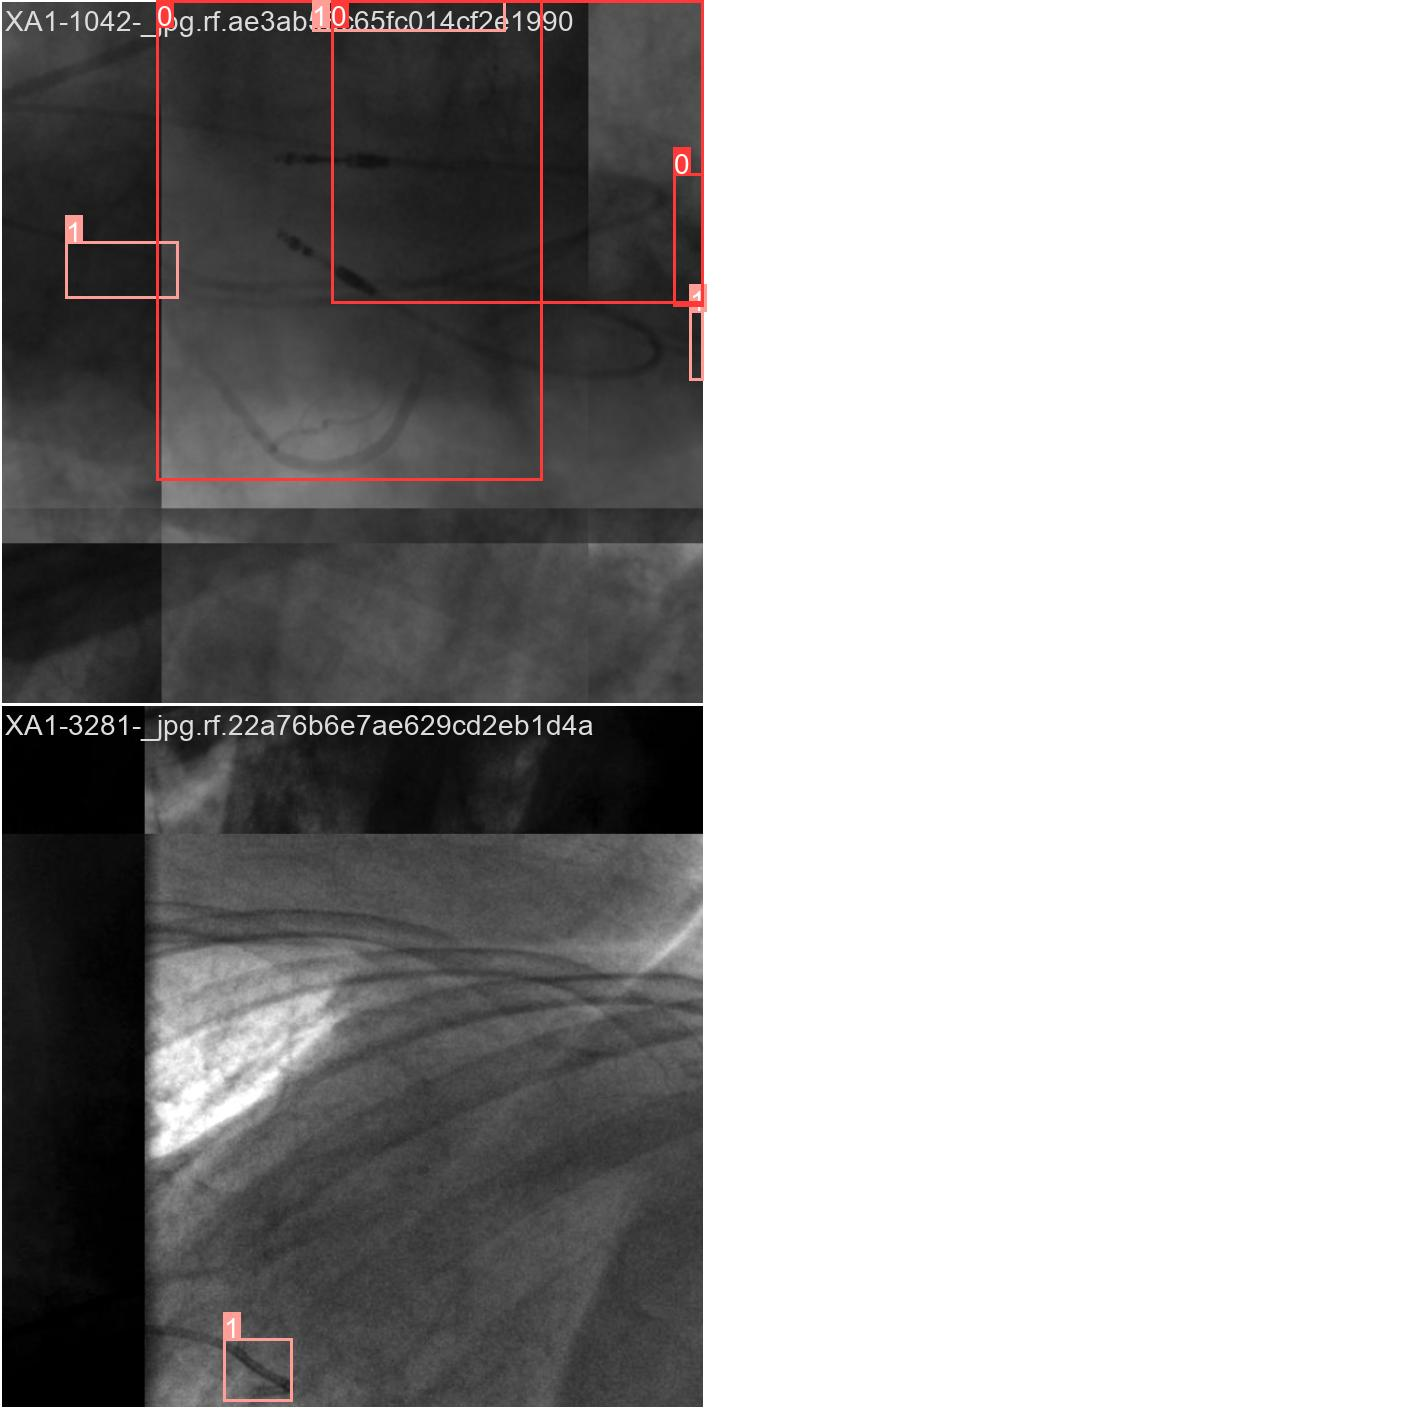

In [31]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='runs/train/exp18/train_batch0.jpg', width=900)

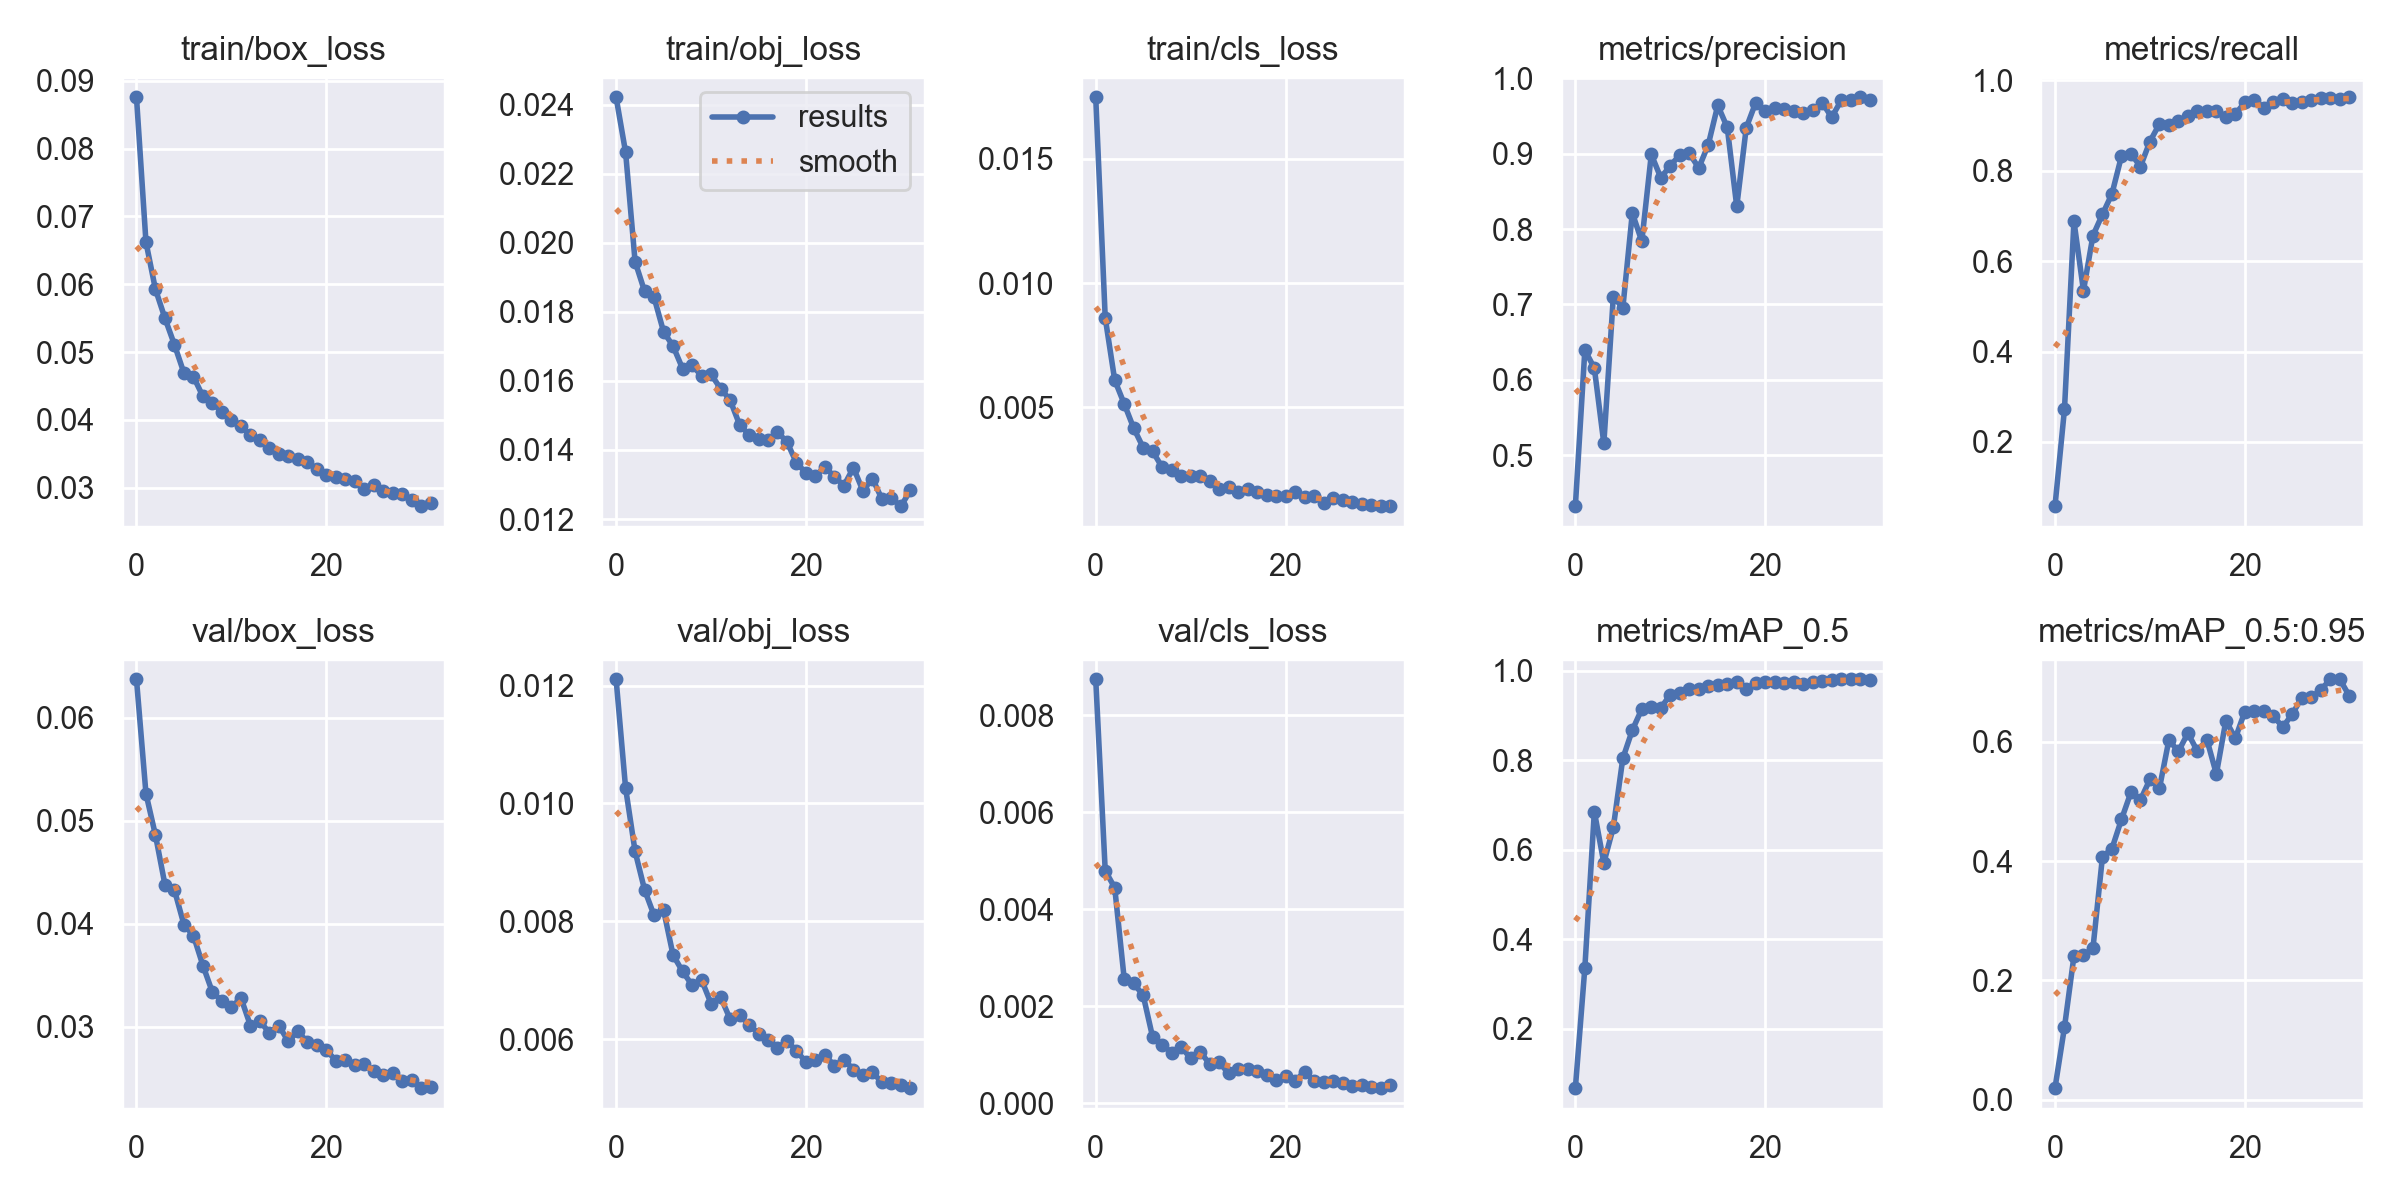

In [30]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='runs/train/exp18/results.png', width=1000)  # view results.png

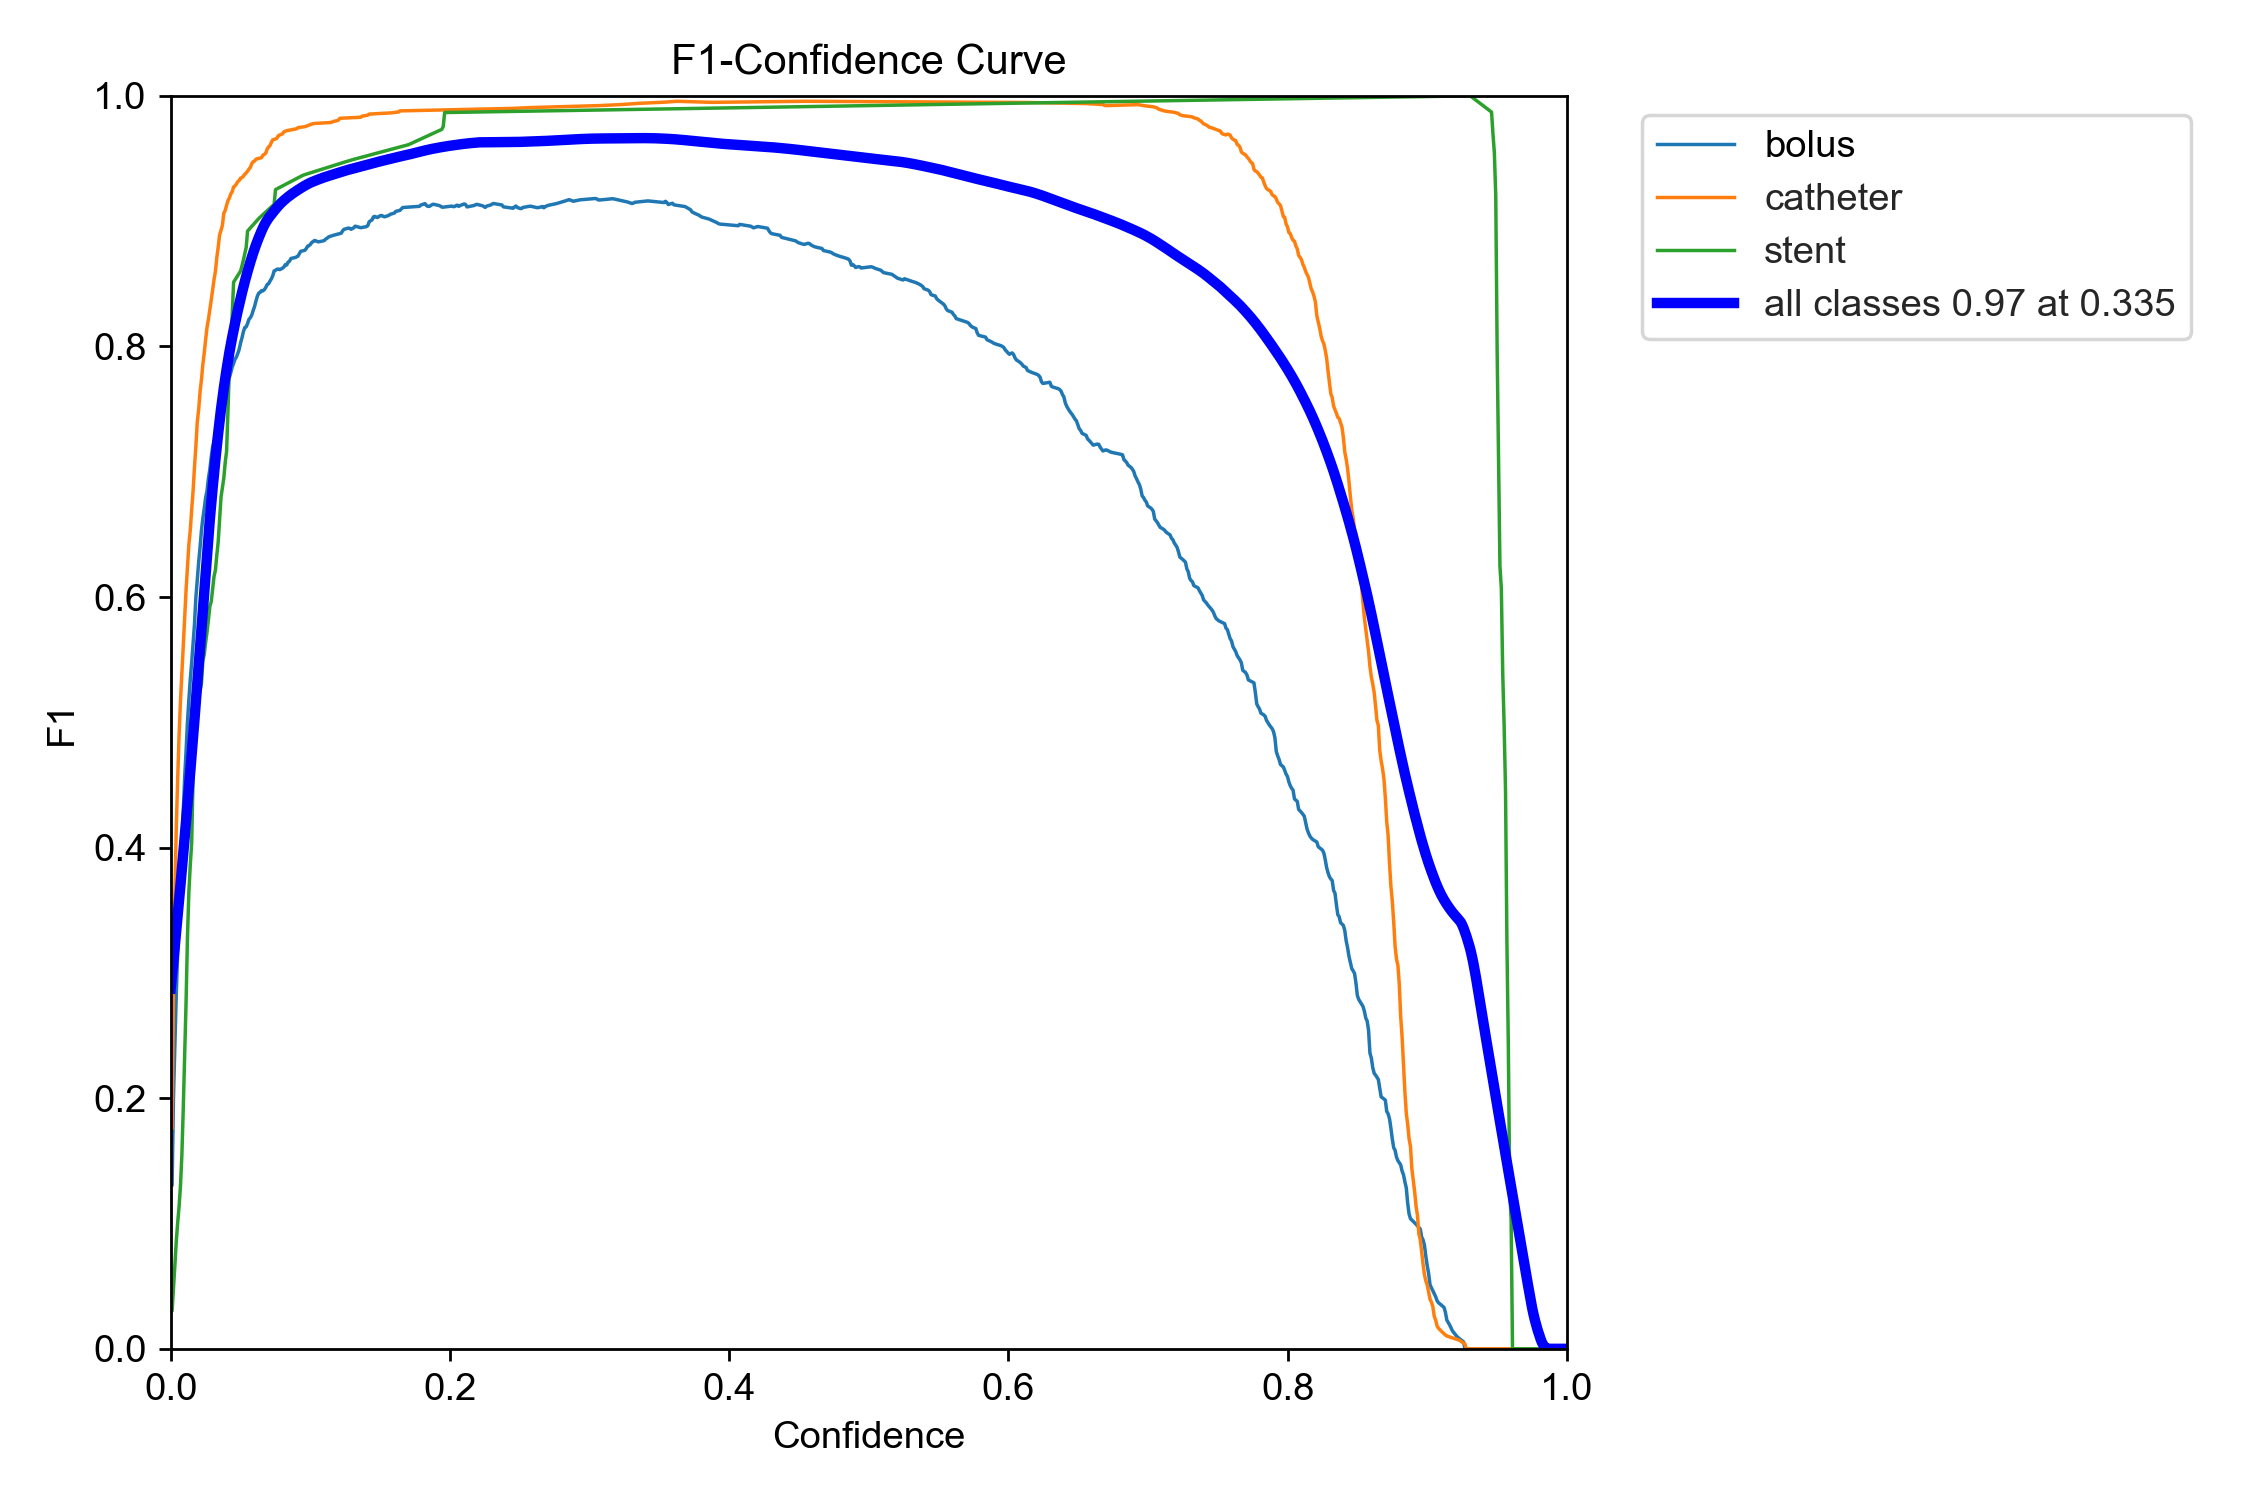

In [29]:
Image(filename='runs/train/exp18/F1_curve.png', width=1000)  # view results.png

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/exp9/val_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


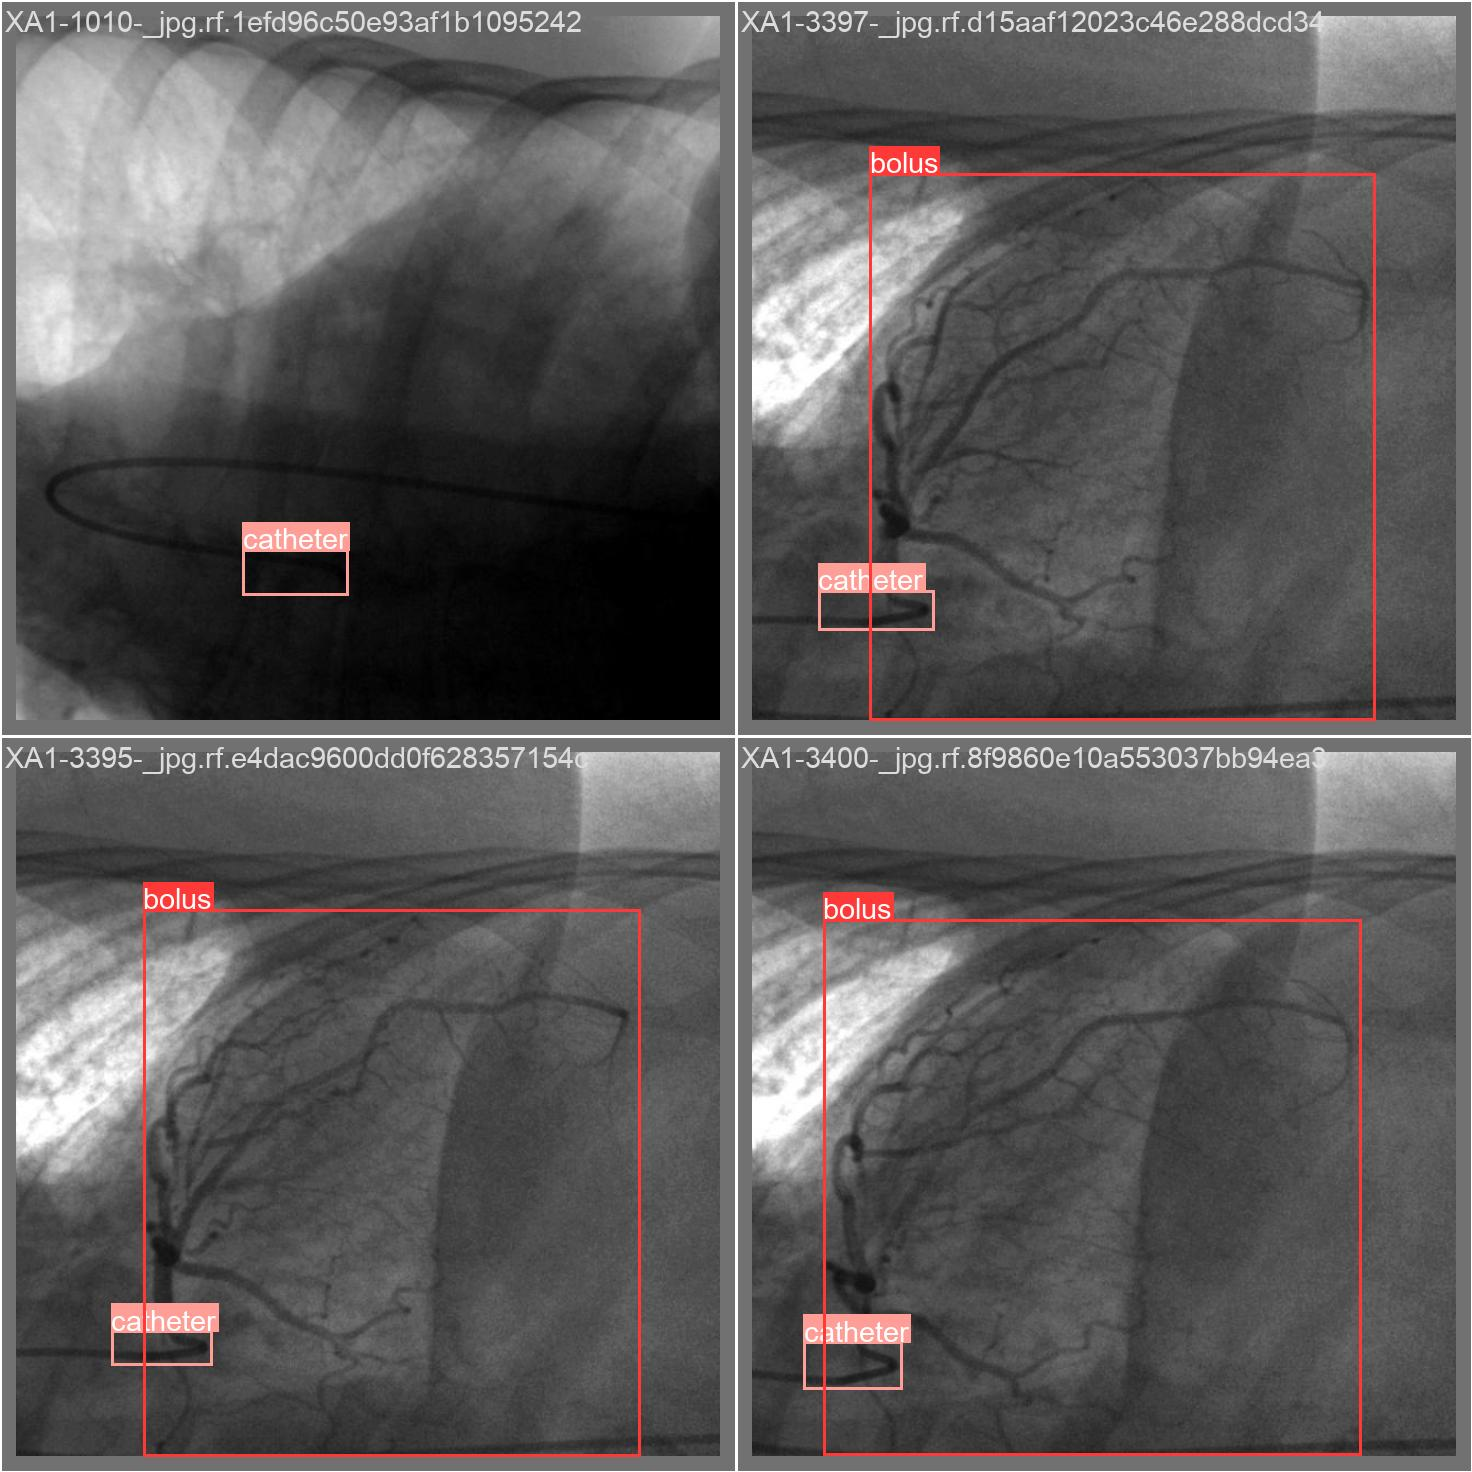

In [28]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/exp18/val_batch0_labels.jpg', width=900)

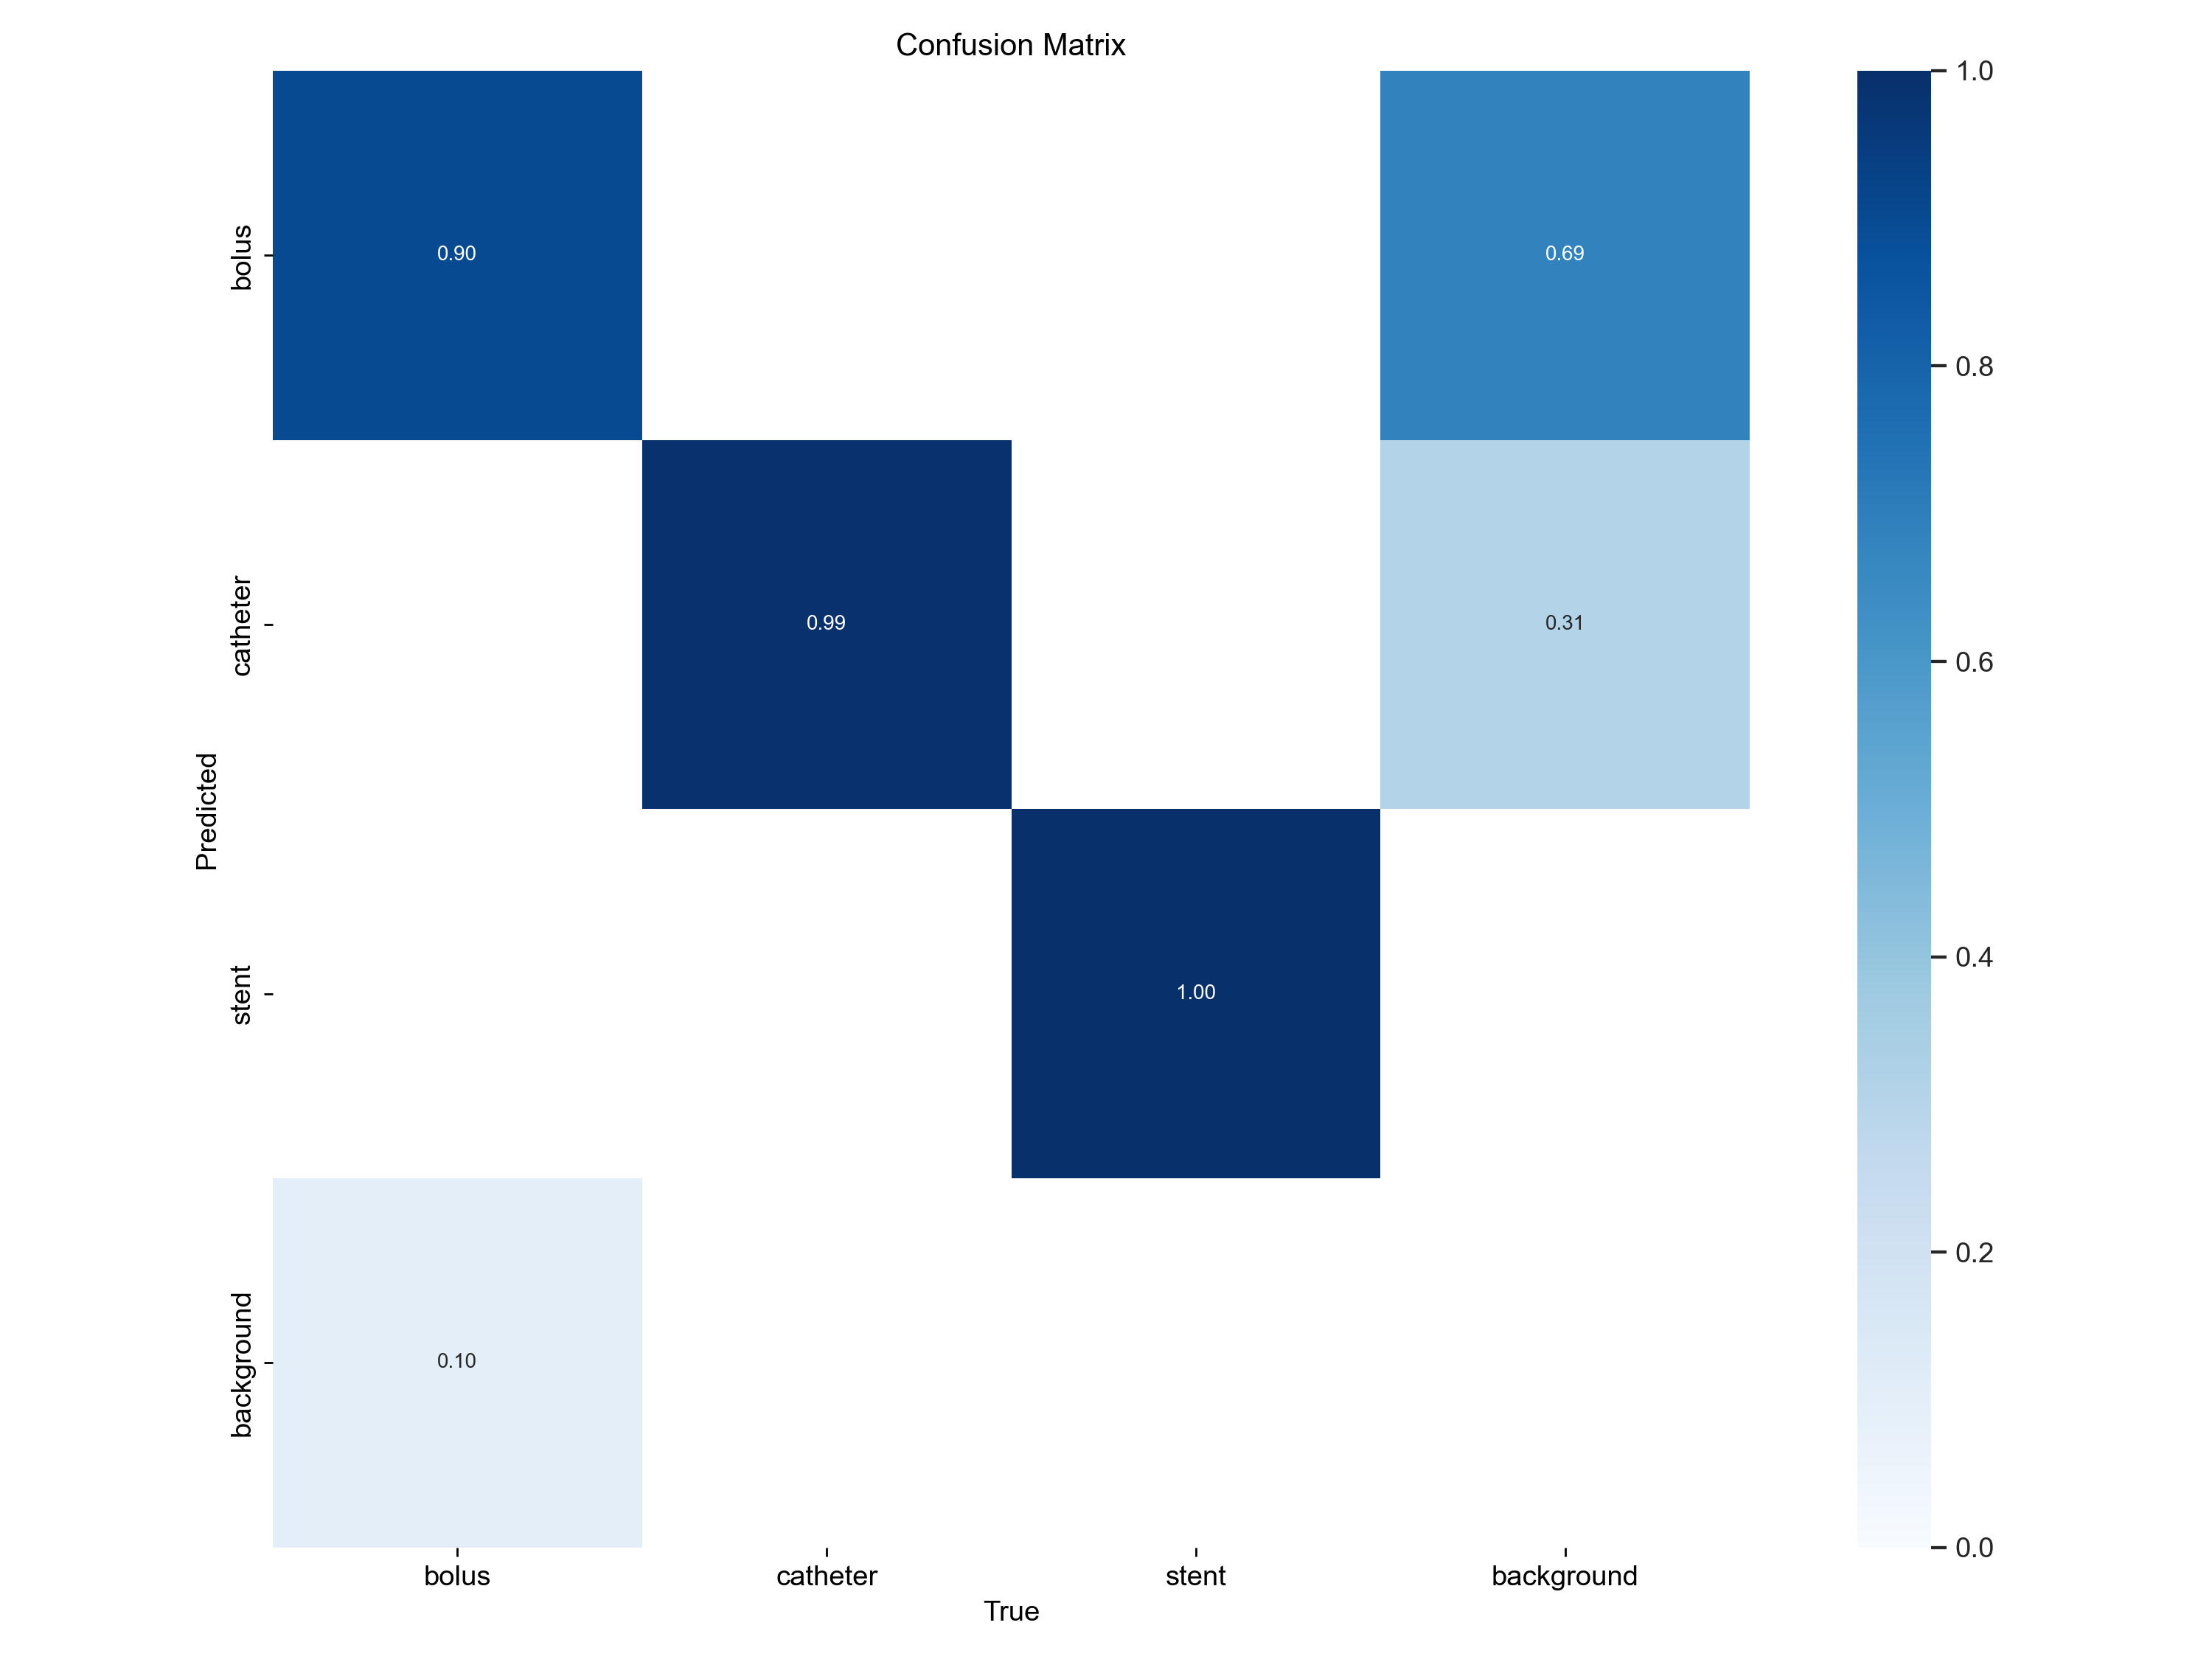

In [20]:
Image(filename='runs/train/exp18/confusion_matrix.png', width=1000)  # view results.png

In [ ]:
!python detect.py --weights runs/train/exp9/weights/last.pt --conf 0.1 --source train_test_dataset_three_classes/images/test

In [21]:
!python detect.py --weights runs/train/exp18/weights/last.pt --conf 0.1 --source detr-xray-2/test/images

detect: weights=['runs/train/exp18/weights/last.pt'], source=detr-xray-2/test/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-304-g22361691 Python-3.8.19 torch-1.11.0+cu113 CUDA:0 (NVIDIA RTX A4000, 16375MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/290 C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1000-_jpg.rf.0b8ca8e26f8589fbbc1d692f7596e970.jpg: 640x640 1 bolus, 1 catheter, 11.0ms
image 2/290 C:\Users\mdiehl\yolov5\detr-xray-2\test\images\XA1-1006-_jpg.rf.778404a81d8cc36b48c2b02c3802e58f.jpg: 640x640 1 catheter, 11.0ms
image 3/290 C:\Users\mdie

In [ ]:
!python val.py --weights runs/train/exp9/weights/last.pt --data train_test_dataset_three_classes/omega_classes.yaml --img 680 --half

In [22]:
!python val.py --weights runs/train/exp18/weights/last.pt --data detr-xray-2/data.yaml --img 680 --half

val: data=detr-xray-2/data.yaml, weights=['runs/train/exp18/weights/last.pt'], batch_size=32, imgsz=680, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5  v7.0-304-g22361691 Python-3.8.19 torch-1.11.0+cu113 CUDA:0 (NVIDIA RTX A4000, 16375MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
WARNING  --img-size 680 must be multiple of max stride 32, updating to 704

val: Scanning C:\Users\mdiehl\yolov5\detr-xray-2\valid\labels.cache... 577 images, 0 backgrounds, 0 corrupt: 100%|##########| 577/577 [00:00<?, ?it/s]
val: Scanning C:\Users\mdiehl\yolov5\detr-xray-2\valid\labels.cache... 577 images, 0 backgrounds, 0 corrupt: 100%|##########| 577/577 [00:00<?, ?it/s]

                 Class     Images  Instances          P          R    

In [ ]:
%ls runs/val/exp

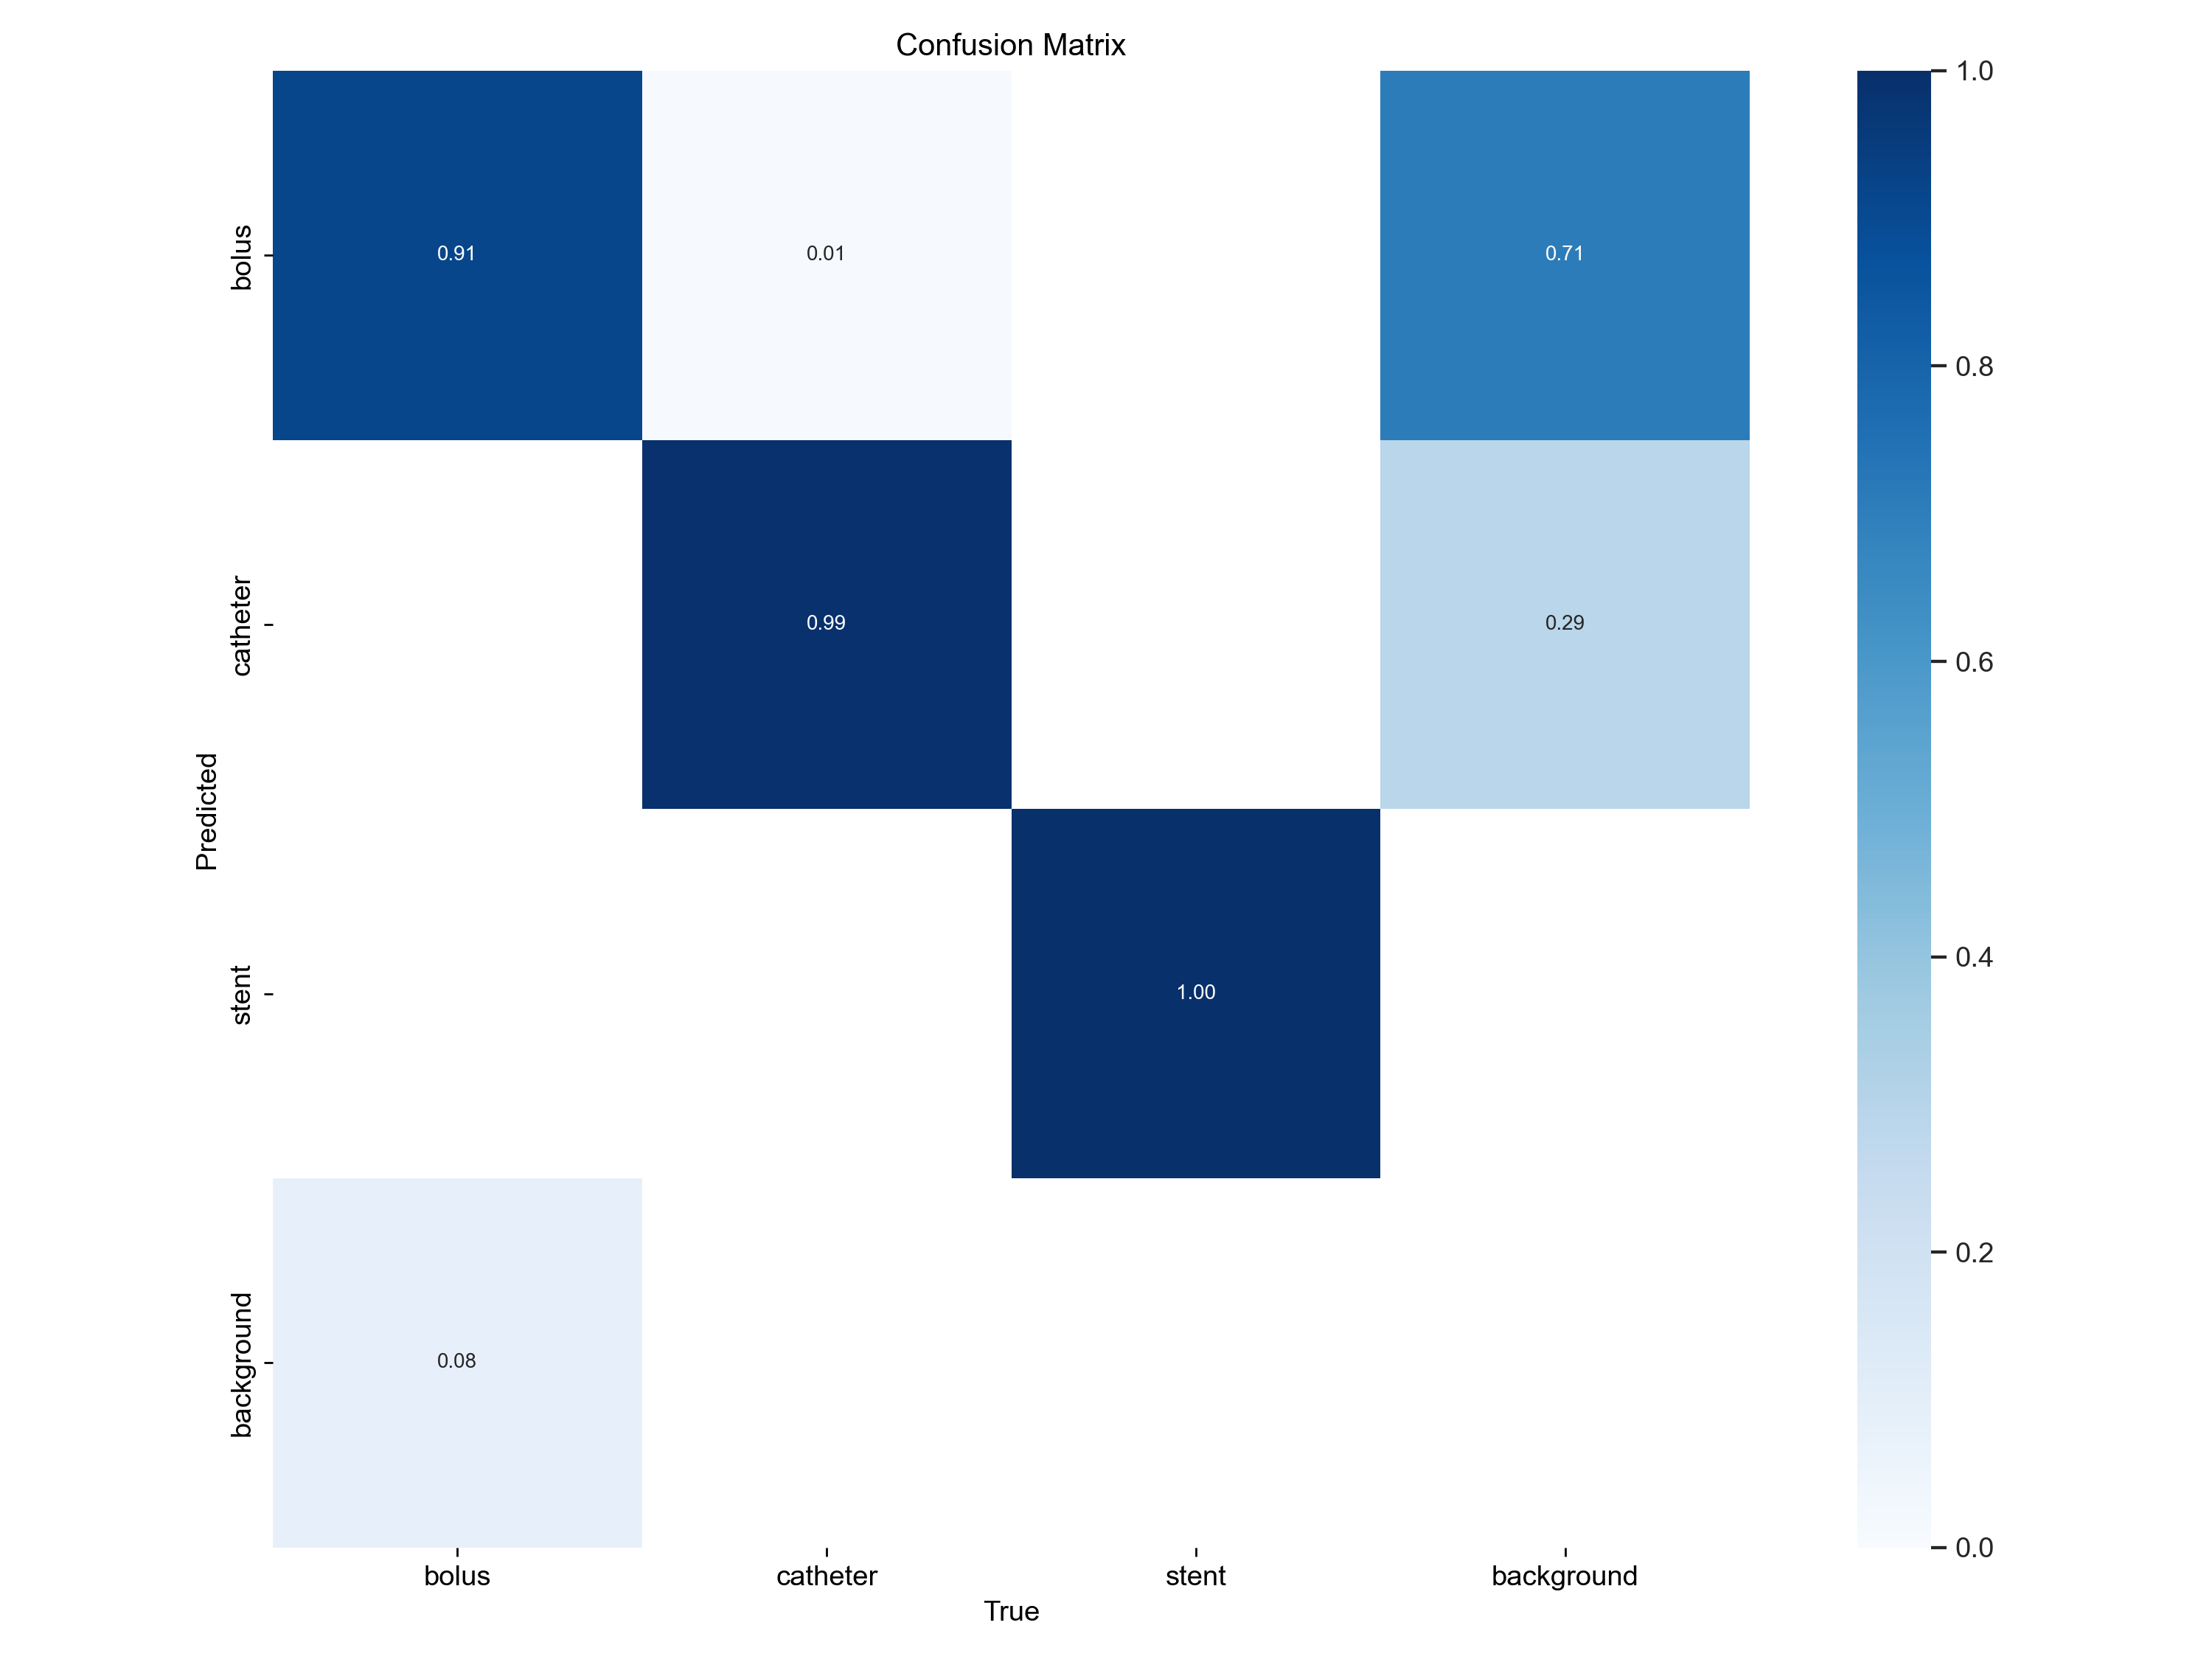

In [23]:
Image(filename='runs/val/exp5/confusion_matrix.png', width=1000)  # view confusion_matrix

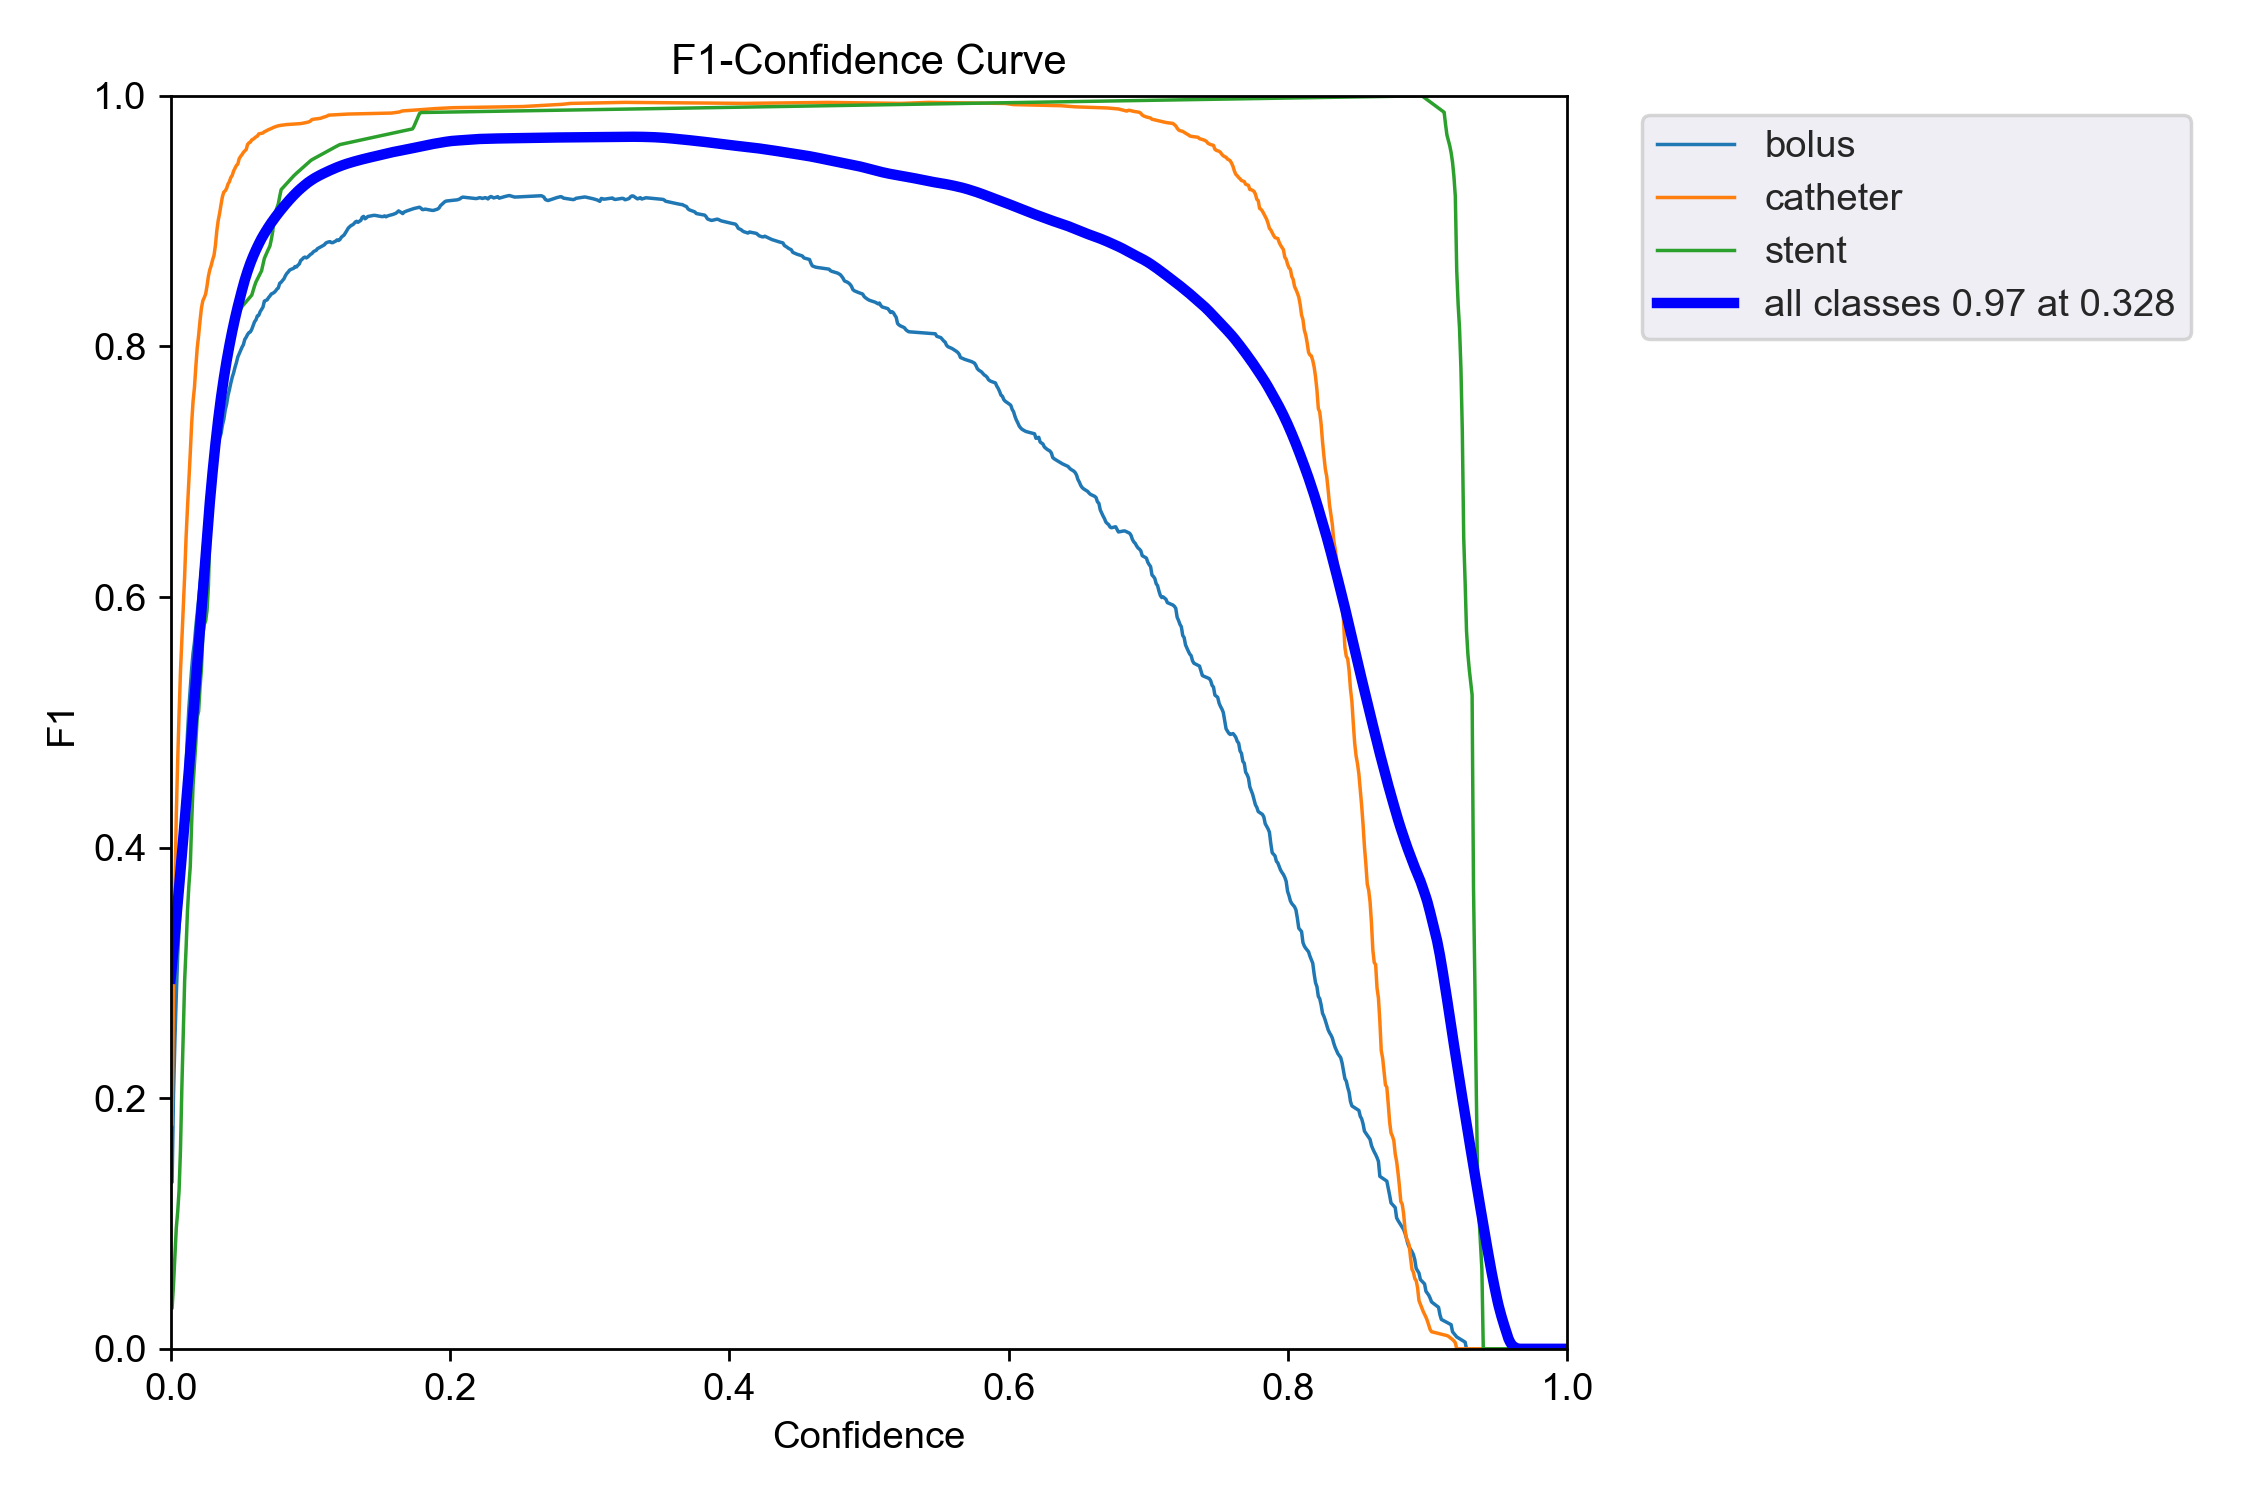

In [24]:
Image(filename='runs/val/exp5/F1_curve.png', width=1000)  # view F1 Score curve

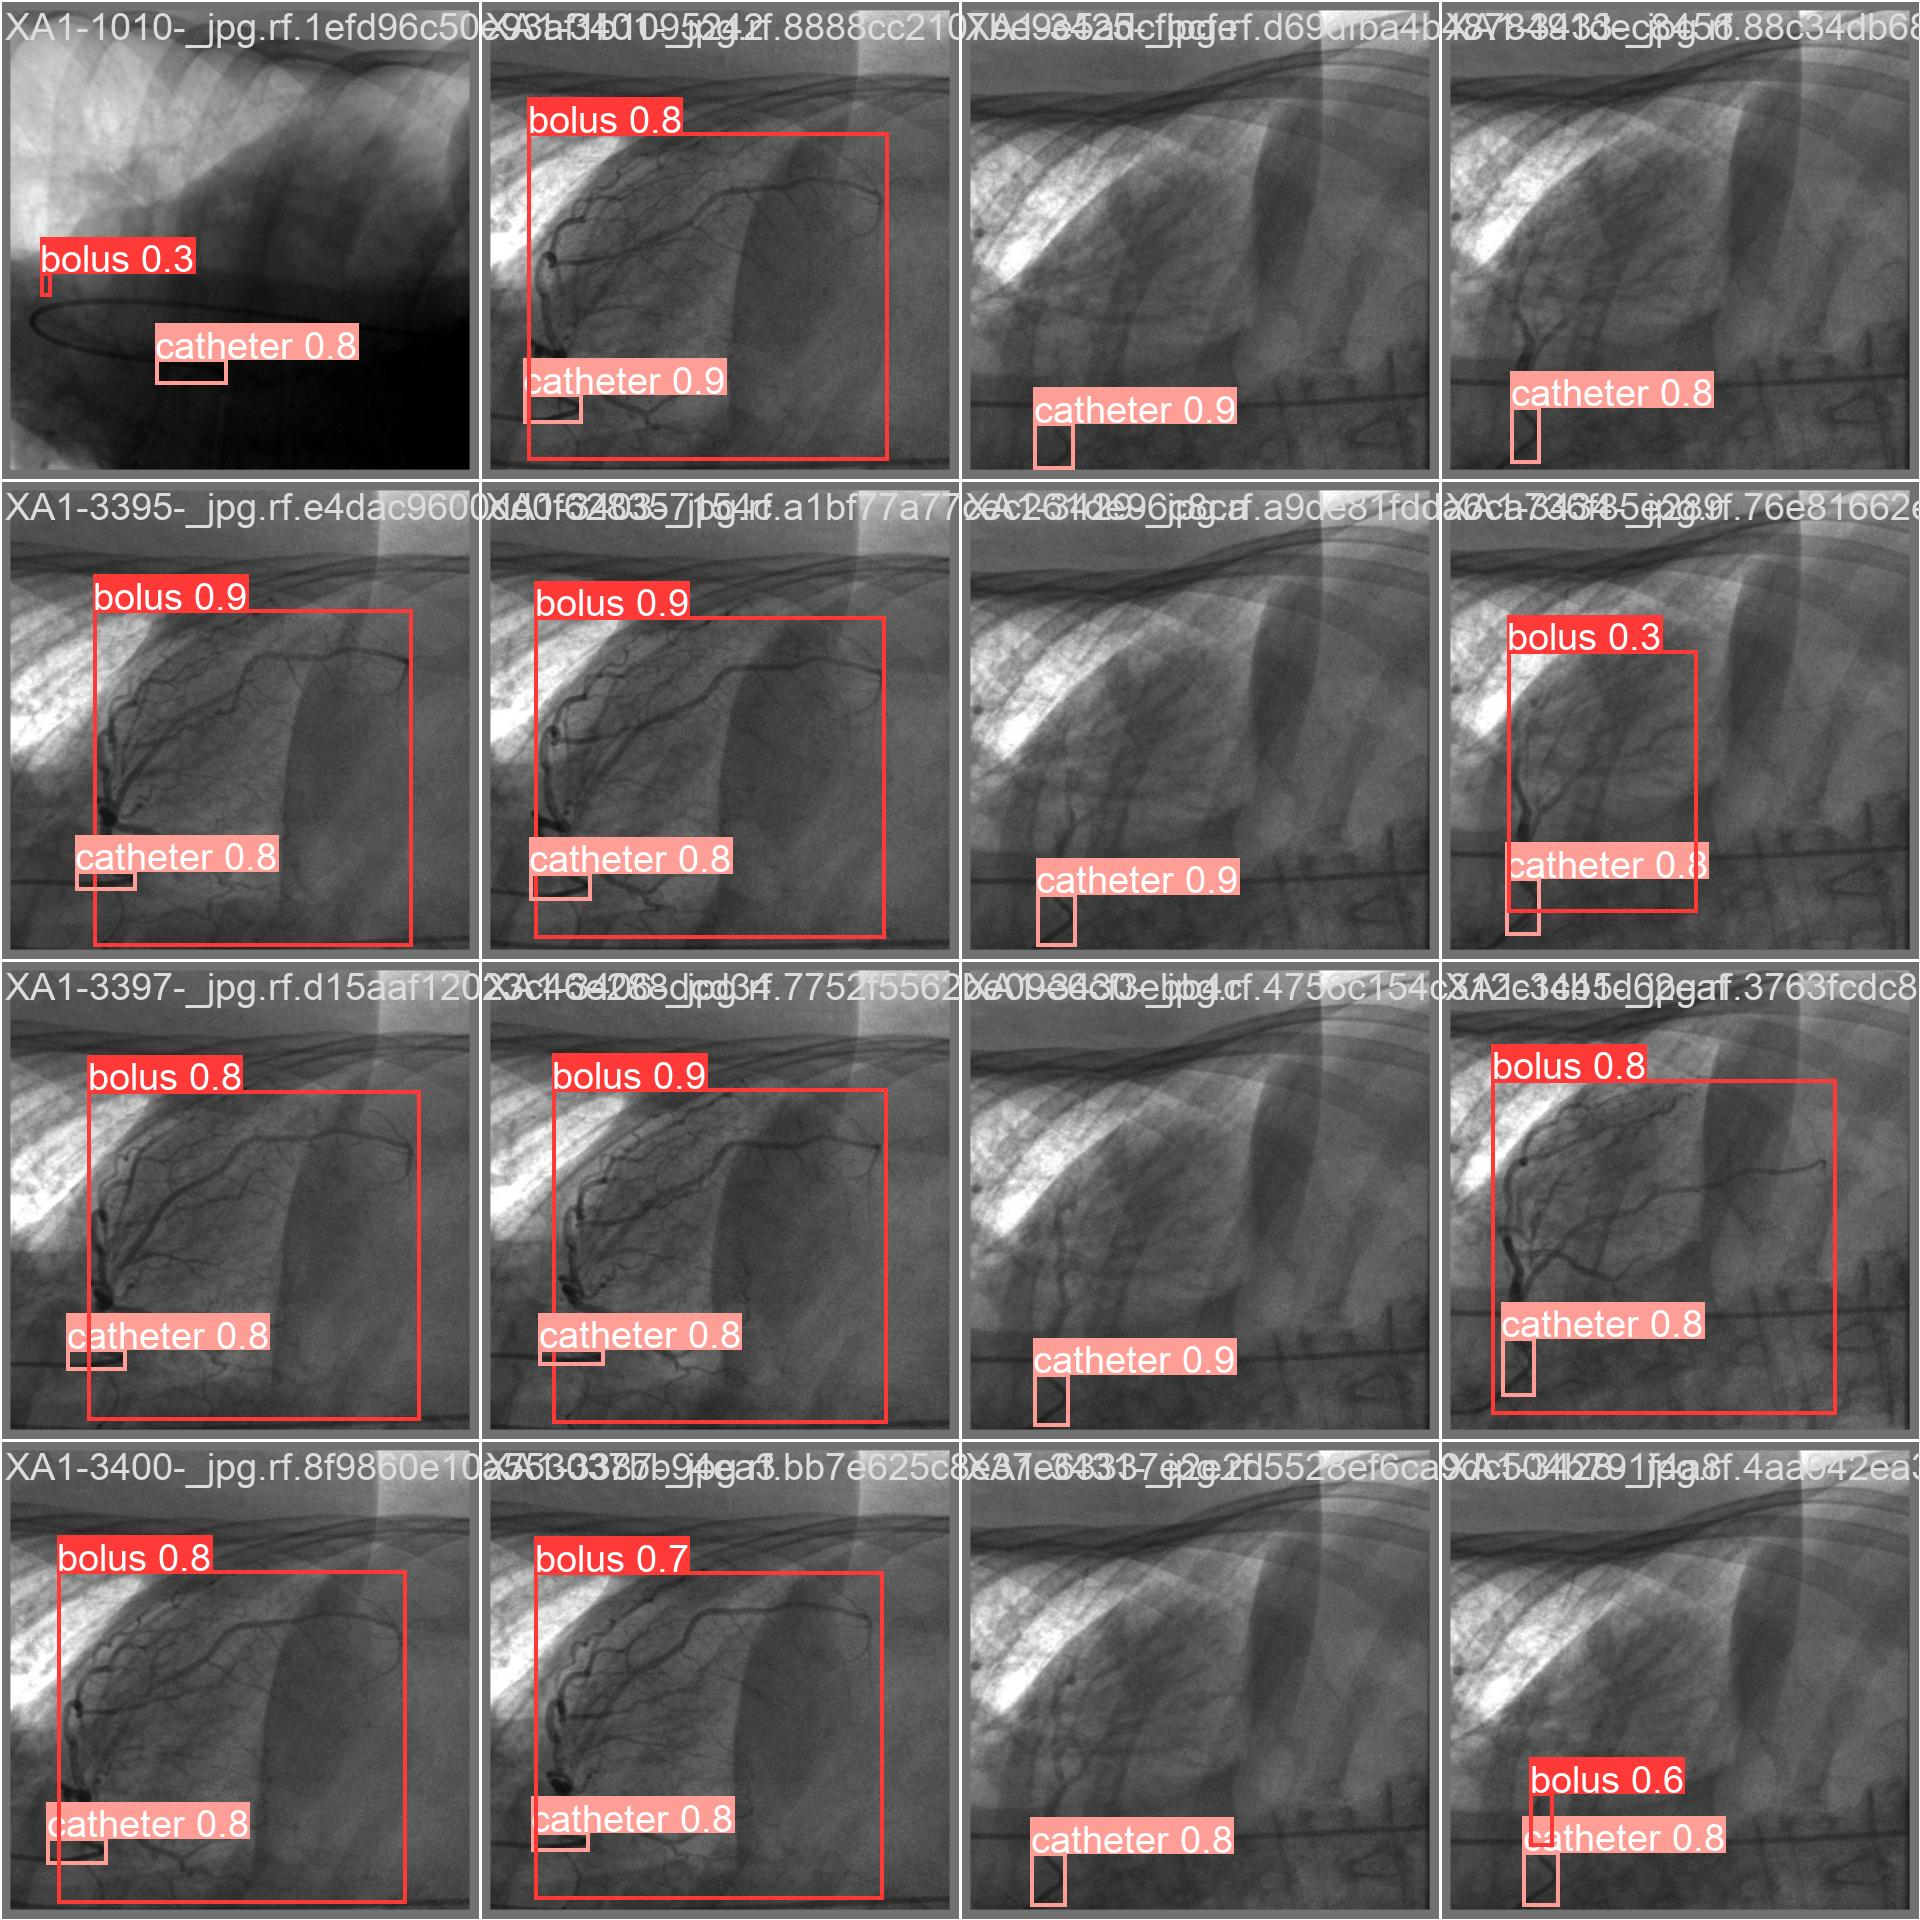

In [27]:
Image(filename='runs/val/exp5/val_batch0_pred.jpg', width=1000)  # view predictions

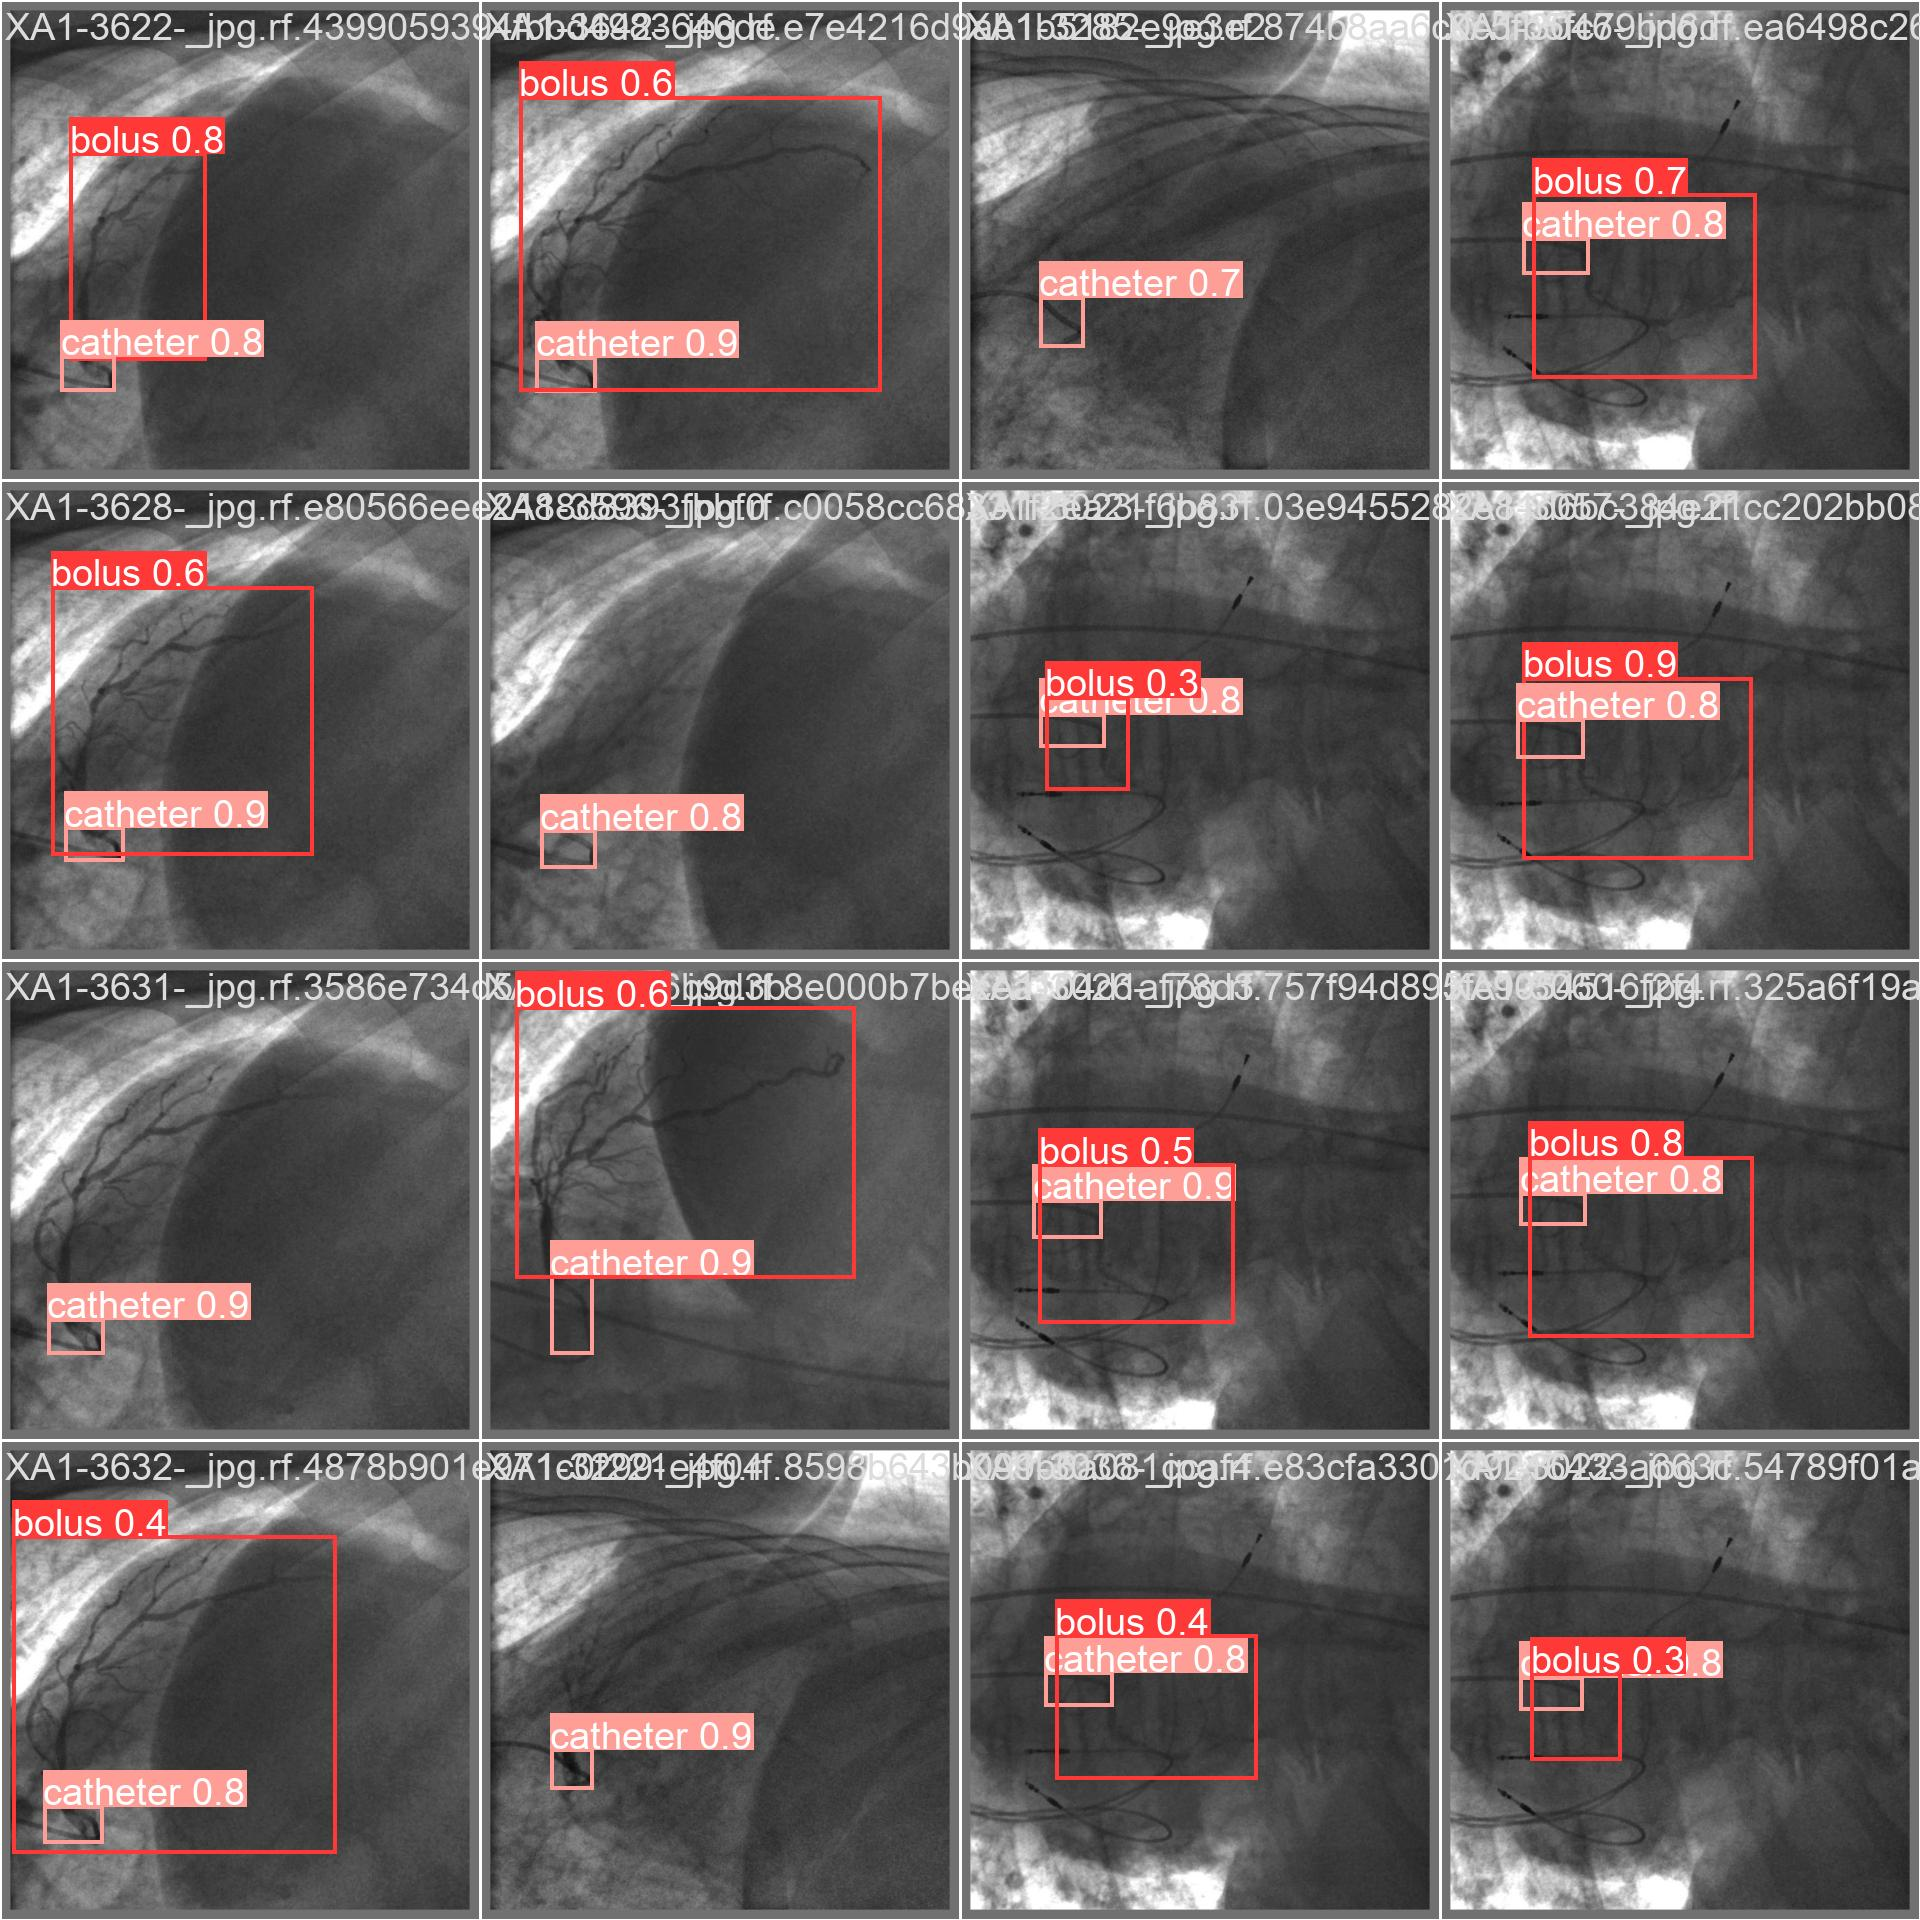

In [25]:
Image(filename='runs/val/exp5/val_batch2_pred.jpg', width=1000)  # view ground truth

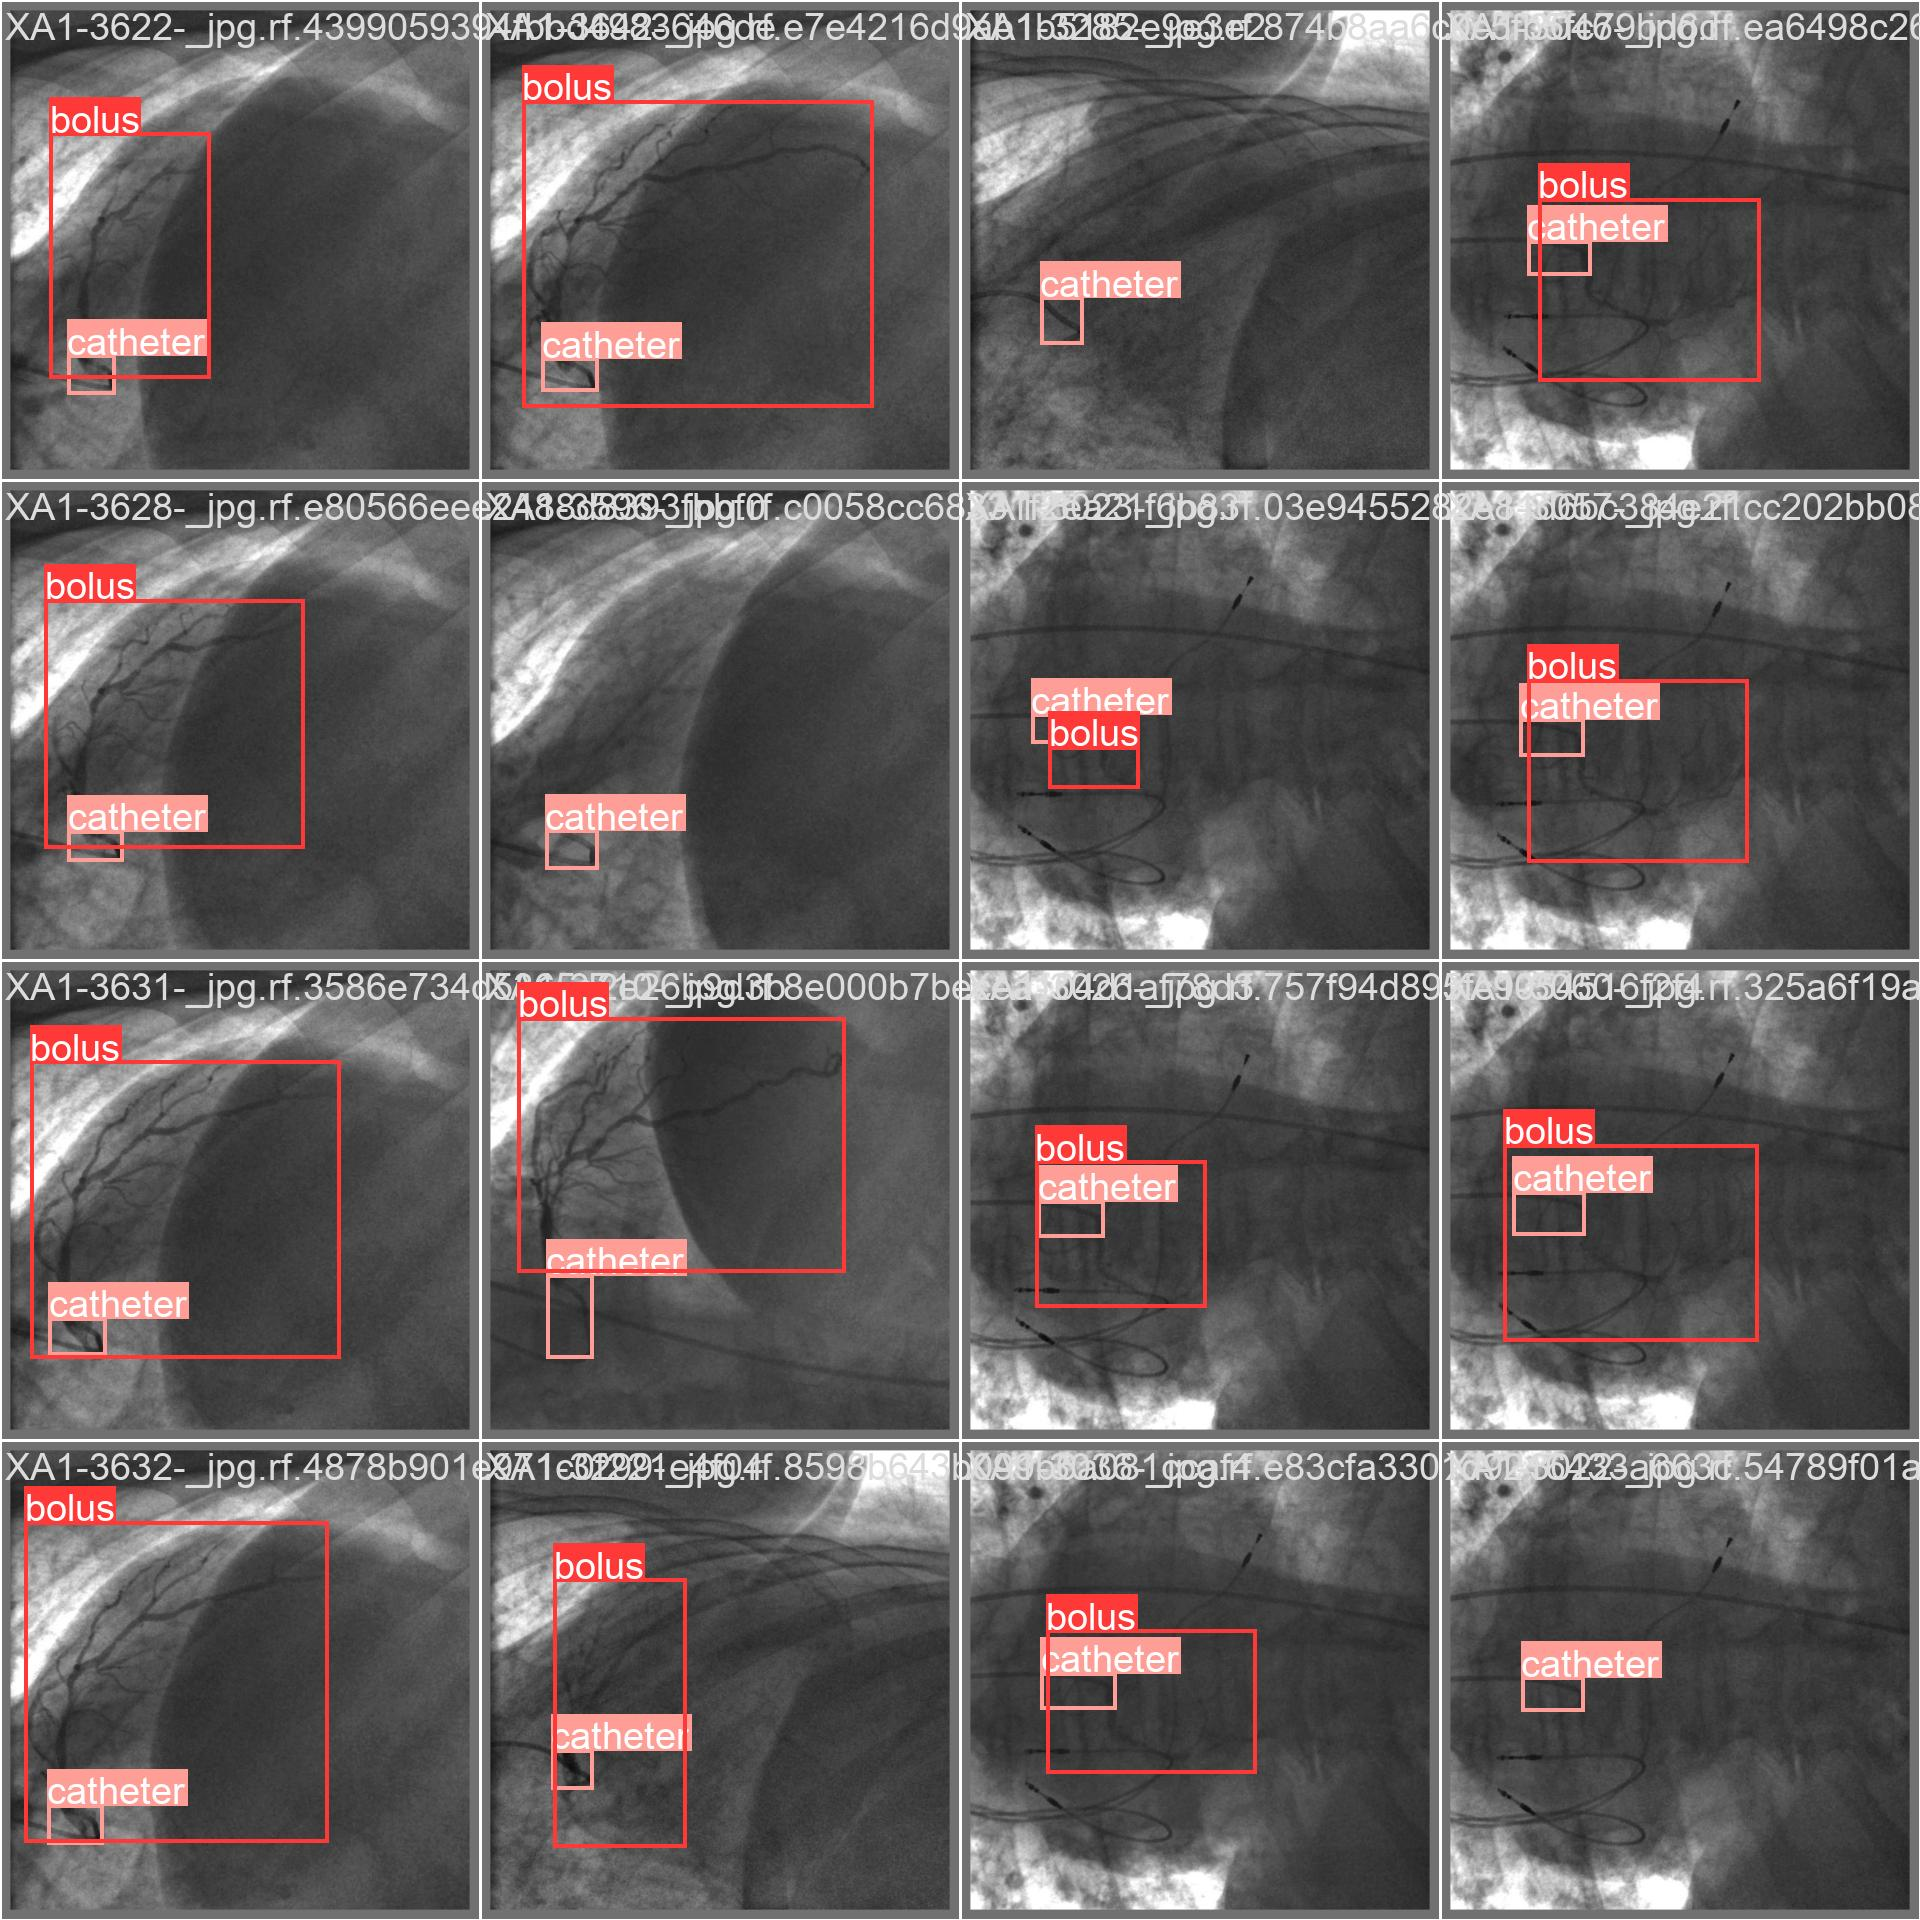

In [26]:
Image(filename='runs/val/exp5/val_batch2_labels.jpg', width=1000)  # view ground truth